### DataSciene Spring 2019 Now You "C" Me Group
link to video: https://youtu.be/lhodcPtmywc

# Schwann Cell Vitamin C Data Normalization

## Introduction to what I am doing here

This is going to be a copy of the ARPE-19 Data Normalization. I am going to keep all of the information about how I normalize the data and simply update the actual code for changes in file names, sample numbers, cutoff points, etc. This should mirror the ARPE_normalizing.RNA.and.hMeDIP.ipynb notebook very closely.

To start with, I have my raw count files. I have combined them already (using bash scripting), so it is in table format where it is tab delimited like this:

    Gene_ID | Sample 1 | Sample 2 | Sample 3 | Sample 4
    ENSRN0001 | 6 | 8 | 24| 29
    ENSRN0002 | 12 | 13 | 14 | 13
    ENSRN0003 | 18 | 17 | 1 | 0

For the RNA I also have results from edgeR and DESeq2. I have the transcript info from the GTF file in a csv file that I will use to determine transcript length.

For the hMeDIP samples I also have the edgeR statistical analysis, the bed file stating the location of the each peak (chromosome, start, stop, name of peak), the count data for genomic input (which was used for the peak calling and will be used for determining the cutoff of expression) and the region_analysis output which tells which gene the peak is close to. 

RNA-seq samples were aligned using STAR and then quantified using htseq-count. Both edgeR and DESeq2 are used for differential analysis and genes below a false discovery rate (FDR, also called adjusted P-value) of 0.05 by both DESeq2 and edgeR will be called differential. A limit of detection will be calculated using the genomic input from the hMeDIP-seq portion of the experiment. 

hMeDIP-seq peaks were called using the irreproducible discovery rate pipeline designed for the ChIP-seq portion of the ENCODE consortium. Counts were generated using htseq-count. Differential analysis was calculated using edgeR. To account for not having a second statistical program (DESeq2 can't normalize to all data), a cutoff of 1.5-fold change will be used in conjunction with an FDR of 0.05 by edgeR to determine differential peaks.

Genes that have more count data after treatment (increase in expression) or peaks that have higher count data (increase in enrichment from the antibody) are considered "Upregulated". Genes that have fewer counts or lower coverage (decreae in expression) or peaks that have lower coverage (decreased enrichment from the antibody) are considered "Downregulated". Genes that have relatively similar count data or that do not achieve statistical significant are considered "Nondifferential".




### hMeDIP-seq normalization 

In this particular jupyter notebook, I am going to be cleaning up the data. This has many steps, and I am going to save many intermediate files. Most of those files will not be used in the correlation or classification parts of this project, but the files are still useful for this project and may be used in future directions from this sampleset.

The first step to cleaning up the hMeDIP-seq data is to normalize the counts to the total number of reads. This is a Read Count Per Million (RCPM), but this first one does not exclude outliers. 

The next step is to determine which peaks are outliers. The reason for this is that outliers can bias your normalization. As an example, if you have two samples that are identical, and then you spike in DNA that will be in one region for 50% of one of the samples, your normalization will all be wrong. Instead of saying that your spiked-sample has one peak that is significantly different than what is found in the other sample, all of your peaks look like they have half as much coverage as the non-spiked sample and all regions appear differential. If you remove the one spiked region from the normalization, now the unchanged regions all appear the same between the samples (as they should), but the spiked in reads still appear only in the one sample. For this reason, this step includes a linear regression between the two sample types (in this case control and vitamin C), and then a Cook's value of 1 (can be changed), is used to determine the outliers. 

Once you have identified outliers, you can go back to the raw count data and normalize to total read counts excluding the outliers. This gives you the RCPM. This file is saved as the RCPM table.

The next step is to normalize to the RCPM by the width of each peak. This allows you to compare one peak to another. If you don't do this and you compare one peak that covers 100 base pairs (bp) to another peak that covers 100,000 bp, you would just by chance expect that the secon peak has 1,000 times as many reads. To normalize this, we take the RCPM and multiply by 1,000 and divide by the length of the peak. This is referred to as "Fragments Per Kilobase per Million mapped reads" (FPKM, see Trapnell et al. 2012, Nature Protocols). To do this, I use the peaks bed file, which contains information about the start and stop positions of each peak that can be used to calculate the length of each peak. This file is saved as the FPKM table. 

Once reads are normalized correctly, I incorporate the statistical data. For hMeDIP-seq, I use edgeR and a fold change. Peaks that receive a false-discovery rate (FDR, benjamini-hocherberg correction) below 0.05 and a fold change of 1.5x or greater are considered differential.

The next step is to determine which genes are most likely affected by each peak. To do this I used region_analysis, which is a program developed for the ENCODE project. This tells you which gene is closest to the center of the peak and how far the peak is from the transcription start site (TSS) of the gene. Using this data, I can assign each peak to a gene (or classify it as intergenic), and classify each to a region of the gene (upstream promoter, TSS, downstream promoter or gene body). 

There are a lot more peaks than genes, and most genes contain many peaks. As such, the next step is to determine the counts of peaks in each region per gene. Additionally, these peaks are divided by how they respond to vitamin C (upregulated, downregulated or nondifferential). This file is saved as a counts per gene region file. 


### Normalizing RNA-seq data

Like the hMeDIP-seq data, the RNA-seq data needs to be normalized. The first step is to normalize to the total reads within annotated features, and then to find outliers, just like is done for the hMeDIP-seq. You next go back to the raw count data and normalize to the total read counts within annotated features that are not outliers to get the RCPM table. Next, you use the genomic info file to get the lengths of each transcript and calculate the FPKM. This is essentially identical to the first few steps of hMeDIP-seq, except that we don't include reads that don't lie within annotated features for RNA. 

Next, we need to determine differential genes. For RNA-seq data, we use both edgeR and DESeq2. Genes that receive an FDR value below 0.05 by both edgeR and DESeq2 are considered differential. No fold change limit is taken into account and using two algorithms for differential analysis is thought to limit false positives. 

Again, the fold change is used to split differential genes into upregulated and downregulated genes.

Now, the counts of peaks per gene region are integrated with the RNA-seq data to generate a table that contains information that will be used for our classification analysis. Other information that is kept in the file includes gene biotype (e.g. protein coding, long noncoding RNA, antisense RNA, etc.) and the length of the gene. 

The next step is different than was used for hMeDIP-seq. For the hMeDIP-seq, I used the IDR pipeline (from ENCODE) to determine which regions were highly enriched. However, for RNA we look at all annotated regions. Most of these regions, however, are not going to have any reads. This step is determining which genes are above our limit of detection. To do this, I perform the normalization of the genomic input data. The genomic input data was generated for hMeDIP-seq, but has no enrichment. It is meant to represent what we would get if we sequenced just noise. For the RNA, I draw out density plots of the RNA-seq samples and the genomic input. If we use a limit of detection (LOD) below the highest expressed genomic input, then those are essentially false positives for the LOD. If we use a LOD above the bottom of the true genes, then those true genes below that point ar false negatives for our LOD. For this, I look at the density plot and take the point where the RNA-seq data overlaps the genomic input to find the minimum number of false positives and false negatives. Only the transcripts above the determined LOD are used for the rest of this project. 

#### Reading in the count files and normalizing them
The first step is going to be reading in the count files and normalizing them to total read counts. There will be multiple steps of normalization, but this is the first one.


In [1]:
import numpy as np
import pandas as pd

In [2]:
import os
os.listdir("Input_Data/SC-VitC_Dataset")


['.DS_Store',
 'Merged.SC.LAA.Final.peaks.bed',
 'SC.VitC.hMeDIP.counts.txt',
 'SC.VitC.INPUT.Final.counts.txt',
 'SC.VitC.RNA.DESeq2.csv',
 'SC.VitC.RNA.edgeR.csv',
 'SC.VitC.RNA.counts.txt',
 'SC_VitC_Region_Analysis.bed.txt',
 'SC_VitC.hMeDIP.edgeR.csv']

In [3]:
os.listdir("Input_Data/")

['MM10.Consensus.Transcript.Info.csv',
 '.DS_Store',
 'SC-cAMP_Dataset',
 'HG38.90.Consensus.transcript.info.csv',
 'RN6.91.Consensus.transcript.info.csv',
 'ARPE-19_Dataset',
 'SC-VitC_Dataset']

In [4]:
os.getcwd()

'/Users/david/Documents/David_Sant/Classes/Data_Science_COMP_5360/2019-datascience-homeworks/Final Project/now-u-c-me-datascience-final-project'

In [5]:
Input_path = r"Input_Data/SC-VitC_Dataset/"
Output_Path = r"Output_Tables_and_Results/SC-VitC_Intermediate_Files/"

Input_hMeDIP_Counts_File = Input_path+"SC.VitC.hMeDIP.counts.txt"
Input_hMeDIP_edgeR = Input_path+"SC_VitC.hMeDIP.edgeR.csv"
Input_region_analysis = Input_path+"SC_VitC_Region_Analysis.bed.txt"
Input_Genomic_Input_Counts_File = Input_path+"SC.VitC.INPUT.Final.counts.txt"
Input_bed_file = Input_path+"Merged.SC.LAA.Final.peaks.bed"

Input_RNA_Counts_File = Input_path+"SC.VitC.RNA.counts.txt"
Input_RNA_edgeR = Input_path+"SC.VitC.RNA.edgeR.csv"
Input_RNA_DESeq2 = Input_path+"SC.VitC.RNA.DESeq2.csv"

Input_genomic_info_file = "Input_Data/RN6.91.Consensus.transcript.info.csv"

In [6]:
SC_VitC_hMeDIP_raw = pd.read_csv(Input_hMeDIP_Counts_File, sep = "\t", index_col = 0)

In [7]:
print(len(SC_VitC_hMeDIP_raw))
SC_VitC_hMeDIP_raw.head()

215956


,SC_Control_1_IP,SC_Control_2_IP,SC_Control_3_IP,SC_VitC_1_IP,SC_VitC_2_IP,SC_VitC_3_IP
Peak_Name,,,,,,
"SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merged_peak_92032",153,153,209,96,89,86
"SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merged_peak_92041",119,112,172,116,122,130
SC_Control_IP_Merged_peak_100020,72,73,86,56,50,67
SC_Control_IP_Merged_peak_100028,66,71,93,50,49,57
SC_Control_IP_Merged_peak_10003,73,90,84,53,76,69


In [8]:
# Dave notes, axis = 0 means column wise; axis = 1 means row wise
# so a sum of axis=0 means the counts for the entire column
total_counts_SC_VitC_hMeDIP_Raw = SC_VitC_hMeDIP_raw.sum(axis=0)

In [9]:
total_counts_SC_VitC_hMeDIP_Raw

SC_Control_1_IP    86086627
SC_Control_2_IP    77868883
SC_Control_3_IP    92722840
SC_VitC_1_IP       84388035
SC_VitC_2_IP       89722376
SC_VitC_3_IP       97792960
dtype: int64

In [10]:
total_counts_SC_VitC_hMeDIP_Raw[0]

86086627

In [11]:
SC_VitC_hMeDIP_raw["SC_VitC_Control_1_IP_First_RCPM"] = SC_VitC_hMeDIP_raw["SC_Control_1_IP"]*1000000/total_counts_SC_VitC_hMeDIP_Raw[0]
SC_VitC_hMeDIP_raw["SC_VitC_Control_2_IP_First_RCPM"] = SC_VitC_hMeDIP_raw["SC_Control_2_IP"]*1000000/total_counts_SC_VitC_hMeDIP_Raw[1]
SC_VitC_hMeDIP_raw["SC_VitC_Control_3_IP_First_RCPM"] = SC_VitC_hMeDIP_raw["SC_Control_3_IP"]*1000000/total_counts_SC_VitC_hMeDIP_Raw[2]

SC_VitC_hMeDIP_raw["SC_VitC_VitC_1_IP_First_RCPM"] = SC_VitC_hMeDIP_raw["SC_VitC_1_IP"]*1000000/total_counts_SC_VitC_hMeDIP_Raw[3]
SC_VitC_hMeDIP_raw["SC_VitC_VitC_2_IP_First_RCPM"] = SC_VitC_hMeDIP_raw["SC_VitC_2_IP"]*1000000/total_counts_SC_VitC_hMeDIP_Raw[4]
SC_VitC_hMeDIP_raw["SC_VitC_VitC_3_IP_First_RCPM"] = SC_VitC_hMeDIP_raw["SC_VitC_3_IP"]*1000000/total_counts_SC_VitC_hMeDIP_Raw[5]


In [12]:
SC_VitC_hMeDIP_raw["Control_Average"] = SC_VitC_hMeDIP_raw[["SC_VitC_Control_1_IP_First_RCPM","SC_VitC_Control_2_IP_First_RCPM", "SC_VitC_Control_3_IP_First_RCPM"]].mean(axis=1)
SC_VitC_hMeDIP_raw["VitC_Average"] = SC_VitC_hMeDIP_raw[["SC_VitC_VitC_1_IP_First_RCPM","SC_VitC_VitC_2_IP_First_RCPM", "SC_VitC_VitC_3_IP_First_RCPM"]].mean(axis=1)


In [13]:
SC_VitC_hMeDIP_raw.head()


,SC_Control_1_IP,SC_Control_2_IP,SC_Control_3_IP,SC_VitC_1_IP,SC_VitC_2_IP,SC_VitC_3_IP,SC_VitC_Control_1_IP_First_RCPM,SC_VitC_Control_2_IP_First_RCPM,SC_VitC_Control_3_IP_First_RCPM,SC_VitC_VitC_1_IP_First_RCPM,SC_VitC_VitC_2_IP_First_RCPM,SC_VitC_VitC_3_IP_First_RCPM,Control_Average,VitC_Average
Peak_Name,,,,,,,,,,,,,,
"SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merged_peak_92032",153,153,209,96,89,86,1.777280,1.964841,2.254029,1.137602,0.991949,0.879409,1.998717,1.002987
"SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merged_peak_92041",119,112,172,116,122,130,1.382329,1.438315,1.854991,1.374602,1.359750,1.329339,1.558545,1.354564
SC_Control_IP_Merged_peak_100020,72,73,86,56,50,67,0.836367,0.937473,0.927495,0.663601,0.557275,0.685121,0.900445,0.635332
SC_Control_IP_Merged_peak_100028,66,71,93,50,49,57,0.766670,0.911789,1.002989,0.592501,0.546129,0.582864,0.893816,0.573831
SC_Control_IP_Merged_peak_10003,73,90,84,53,76,69,0.847983,1.155789,0.905926,0.628051,0.847057,0.705572,0.969899,0.726894


In [14]:
# Dave Notes
# The sum of the FPKM columns is always going to be 1,000,000 (when I include all rows) because that is how I normalized it
# 1M/215956 gives the 4.630573 average

SC_VitC_hMeDIP_raw[["Control_Average","VitC_Average" ]].describe()

,Control_Average,VitC_Average
count,215956.000000,215956.000000
mean,4.630573,4.630573
std,1447.013116,1247.218434
min,0.000000,0.000000
25%,0.751918,0.903140
50%,1.128989,1.414585
75%,1.848437,2.354225
max,672443.674108,579597.048471


In [15]:
SC_VitC_hMeDIP_raw.sum(axis=0) # should be 1M for all normalized columns

SC_Control_1_IP                    86086627.0
SC_Control_2_IP                    77868883.0
SC_Control_3_IP                    92722840.0
SC_VitC_1_IP                       84388035.0
SC_VitC_2_IP                       89722376.0
SC_VitC_3_IP                       97792960.0
SC_VitC_Control_1_IP_First_RCPM     1000000.0
SC_VitC_Control_2_IP_First_RCPM     1000000.0
SC_VitC_Control_3_IP_First_RCPM     1000000.0
SC_VitC_VitC_1_IP_First_RCPM        1000000.0
SC_VitC_VitC_2_IP_First_RCPM        1000000.0
SC_VitC_VitC_3_IP_First_RCPM        1000000.0
Control_Average                     1000000.0
VitC_Average                        1000000.0
dtype: float64

Now I have read in the hMeDIP count files and done the first normalization, a read count per million (RCPM). This does not take out any outliers, nor does it take out any of the columns that are added by htseq-count that are reads not within annotated features. Notice that the RCPM files all add up to 1,000,000 which is why this is read counts per million. 

The next step will be to determine if there are any outliers that should be taken out of the normalization. I will determine outliers without the htseq columns, but they will be added back in for the final RCPM normalization. For this step, I run a linear regression of the averages per treatment type (vitamin C and control). I look for a cook's cutoff value (usually a value of 1 is used), and then I remove those points that have a high cooks value for the normalization. 

In [16]:
columns_added_by_htseq = ["__no_feature", "__ambiguous", "__too_low_aQual", "__not_aligned", "__not_aligned", "__alignment_not_unique"]

In [17]:
SC_VitC_hMeDIP_first_RCPM_averages = SC_VitC_hMeDIP_raw[["Control_Average","VitC_Average" ]].drop(columns_added_by_htseq, axis = 0)

In [18]:
len(SC_VitC_hMeDIP_first_RCPM_averages)

215951

In [19]:
SC_VitC_hMeDIP_first_RCPM_averages.tail()

,Control_Average,VitC_Average
Peak_Name,,
"SC_LAA_IP_Merged_peak_99980,SC_Control_IP_Merged_peak_108098,SC_Control_IP_Merged_peak_108099",3.928521,5.171365
SC_LAA_IP_Merged_peak_99990,0.577147,1.013082
SC_LAA_IP_Merged_peak_99994,0.704897,1.050162
SC_LAA_IP_Merged_peak_99995,0.672715,1.438460
SC_LAA_IP_Merged_peak_99999,0.676871,1.259336


In [20]:
SC_VitC_hMeDIP_first_RCPM_averages.describe()

,Control_Average,VitC_Average
count,215951.000000,215951.000000
mean,1.516772,1.946717
std,1.289185,1.799536
min,0.114734,0.033293
25%,0.751923,0.903152
50%,1.128992,1.414600
75%,1.848421,2.354188
max,38.952486,74.566169


It looks like the mean for vitamin C is slightly higher, but that is not too surprising because vitamin C leads to a global increase in 5hmC. However, the minimum is lower in the vitamin C treated. I have seen this in all the other datasets too.

Now I have to make a linear regression using the averages and figure out which ones are outliers.
<br>I will not graph it using the ones that start with "_" because they need to be included in normalization because it is immunoprecipitation and this makes it include reads not within peaks.
<br>I am choosing to use cook's cutoff to determine outliers because it takes both X and Y axes into consideration, and it is used by DESeq2 for their normalization. Additionally, it calculates a P-value giving an easier time to determining a cutoff and it runs quickly. I am going to exclude points where Cook's distance > 1 because this looks correct in the graph and this is the default for DESeq2.   


In [21]:
# imports and setup 
import pandas as pd
import scipy as sc
import numpy as np

import statsmodels.formula.api as sm
import statsmodels as stats

import matplotlib.pyplot as plt 
import matplotlib as mpl
plt.style.use('ggplot')
%matplotlib inline  
plt.rcParams['figure.figsize'] = (10, 6) 

In [22]:
from statsmodels.stats import outliers_influence
import statsmodels.stats

In [23]:

linear_model = sm.ols(formula="VitC_Average ~ Control_Average", data=SC_VitC_hMeDIP_first_RCPM_averages).fit()
linear_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           VitC_Average   R-squared:                       0.761
Model:                            OLS   Adj. R-squared:                  0.761
Method:                 Least Squares   F-statistic:                 6.891e+05
Date:                Tue, 16 Apr 2019   Prob (F-statistic):               0.00
Time:                        20:48:56   Log-Likelihood:            -2.7857e+05
No. Observations:              215951   AIC:                         5.571e+05
Df Residuals:                  215949   BIC:                         5.572e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.0993      0.003     33.986      0.000       0.094       0.105
Control_Average     1.2180      0.001    830.145      0.000       1.215       1.221
==============================================================================
Omnibus:                    98885.946   Durbin-Watson:                   1.219
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          6466490.506
Skew:                           1.381   Prob(JB):                         0.00
Kurtosis:                      29.665   Cond. No.                         3.57
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [24]:
influence = linear_model.get_influence()
(cook,p_cook) = influence.cooks_distance
SC_VitC_hMeDIP_first_RCPM_averages["Cook_Value"] = cook
SC_VitC_hMeDIP_first_RCPM_averages["Cook_P_Value"] = p_cook

In [25]:
SC_VitC_hMeDIP_first_RCPM_averages.tail()

,Control_Average,VitC_Average,Cook_Value,Cook_P_Value
Peak_Name,,,,
"SC_LAA_IP_Merged_peak_99980,SC_Control_IP_Merged_peak_108098,SC_Control_IP_Merged_peak_108099",3.928521,5.171365,1.111452e-06,0.999999
SC_LAA_IP_Merged_peak_99990,0.577147,1.013082,2.039855e-07,1.000000
SC_LAA_IP_Merged_peak_99994,0.704897,1.050162,3.567120e-08,1.000000
SC_LAA_IP_Merged_peak_99995,0.672715,1.438460,1.156832e-06,0.999999
SC_LAA_IP_Merged_peak_99999,0.676871,1.259336,4.808550e-07,1.000000


In [26]:
SC_VitC_hMeDIP_removing_outliers = SC_VitC_hMeDIP_first_RCPM_averages[SC_VitC_hMeDIP_first_RCPM_averages.Cook_Value <= 1]
SC_VitC_hMeDIP_outliers = SC_VitC_hMeDIP_first_RCPM_averages[SC_VitC_hMeDIP_first_RCPM_averages.Cook_Value > 1]

In [27]:
SC_VitC_hMeDIP_outliers

,Control_Average,VitC_Average,Cook_Value,Cook_P_Value
Peak_Name,,,,
"SC_LAA_IP_Merged_peak_398730,SC_Control_IP_Merged_peak_435301,SC_LAA_IP_Merged_peak_398731,SC_Control_IP_Merged_peak_435302,SC_Control_IP_Merged_peak_435303,SC_Control_IP_Merged_peak_435306,SC_Control_IP_Merged_peak_435309,SC_Control_IP_Merged_peak_435311,SC_Control_IP_Merged_peak_435312,SC_Control_IP_Merged_peak_435313",38.952486,74.566169,1.861793,0.155396


In [28]:
outliers_removed_model = sm.ols(formula="VitC_Average ~ Control_Average", data=SC_VitC_hMeDIP_removing_outliers).fit()
outliers_removed_model.summary()
# Same R-2 value, but there was only one outlier

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           VitC_Average   R-squared:                       0.761
Model:                            OLS   Adj. R-squared:                  0.761
Method:                 Least Squares   F-statistic:                 6.863e+05
Date:                Tue, 16 Apr 2019   Prob (F-statistic):               0.00
Time:                        20:48:56   Log-Likelihood:            -2.7809e+05
No. Observations:              215950   AIC:                         5.562e+05
Df Residuals:                  215948   BIC:                         5.562e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.1034      0.003     35.452      0.000       0.098       0.109
Control_Average     1.2152      0.001    828.418      0.000       1.212       1.218
==============================================================================
Omnibus:                    91835.391   Durbin-Watson:                   1.219
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          4794693.889
Skew:                           1.282   Prob(JB):                         0.00
Kurtosis:                      25.941   Cond. No.                         3.57
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

From the statsmodels website: http://www.statsmodels.org/dev/generated/statsmodels.stats.outliers_influence.OLSInfluence.summary_frame.html
<br>cooks_d : Cook’s Distance defined in Influence.cooks_distance
<br>standard_resid : Standardized residuals defined in Influence.resid_studentized_internal
<br>hat_diag : The diagonal of the projection, or hat, matrix defined in Influence.hat_matrix_diag
<br>dffits_internal : DFFITS statistics using internally Studentized residuals defined in Influence.dffits_internal
<br>dffits : DFFITS statistics using externally Studentized residuals defined in Influence.dffits
<br>student_resid : Externally Studentized residuals defined in Influence.resid_studentized_external

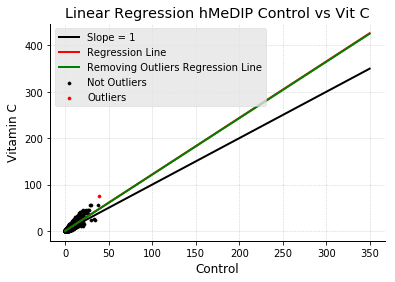

In [29]:
#outliers = ARPE_hMeDIP_outliers["VitC_Average"].values
fig, tmp = plt.subplots()
ax = SC_VitC_hMeDIP_removing_outliers.plot.scatter(y = "VitC_Average", x = "Control_Average", 
                                                ax=tmp, color = 'k', label = "Not Outliers", s = 10)
ax.scatter(y = SC_VitC_hMeDIP_outliers["VitC_Average"], x = SC_VitC_hMeDIP_outliers["Control_Average"], 
           color = 'r', label="Outliers", s = 10)

x_straight = sc.linspace(0, 350, 10)
y_straight = x_straight # I want this line to be a straight line with a slope of 1

plt.title("Linear Regression hMeDIP Control vs Vit C", color='black')
plt.ylabel("Vitamin C", color='black')
plt.xlabel("Control", color='black')
ax.set_facecolor('white')
ax.tick_params(color='black', labelcolor='black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.grid(color='lightslategray', linestyle='--', linewidth=0.5, alpha=0.4)
plt.tick_params(axis = 'both', which = 'major', labelsize='10')

parameters = linear_model.params
x = sc.linspace(0, 350, 10)
y = parameters[0] + parameters[1]*x

outliers_removed_model
outlier_parameters = outliers_removed_model.params
#x = sc.linspace(0, 350, 10)
outlier_y = outlier_parameters[0] + outlier_parameters[1]*x


plt.plot(x_straight,y_straight,label="Slope = 1", linewidth=2, color='k')
plt.plot(x,y,label="Regression Line", linewidth=2, color='r')
plt.plot(x,outlier_y,label="Removing Outliers Regression Line", linewidth=2, color='g')
plt.legend(loc='upper left')
plt.savefig(Output_Path+"SC_VitC_hMeDIP_Finding_Outliers.png", dpi=300) # size above specified at 10x6
plt.show()
#plt.savefig(Output_Path+"ARPE_hMeDIP_Finding_Outliers.png")

In [30]:
remove_outliers = SC_VitC_hMeDIP_raw.drop(SC_VitC_hMeDIP_outliers.index, axis = 0)
total_counts_removing_outliers = remove_outliers.sum(axis=0)

In [31]:
total_counts_removing_outliers

SC_Control_1_IP                    8.608344e+07
SC_Control_2_IP                    7.786615e+07
SC_Control_3_IP                    9.271869e+07
SC_VitC_1_IP                       8.438199e+07
SC_VitC_2_IP                       8.971516e+07
SC_VitC_3_IP                       9.778596e+07
SC_VitC_Control_1_IP_First_RCPM    9.999630e+05
SC_VitC_Control_2_IP_First_RCPM    9.999649e+05
SC_VitC_Control_3_IP_First_RCPM    9.999553e+05
SC_VitC_VitC_1_IP_First_RCPM       9.999283e+05
SC_VitC_VitC_2_IP_First_RCPM       9.999196e+05
SC_VitC_VitC_3_IP_First_RCPM       9.999284e+05
Control_Average                    9.999610e+05
VitC_Average                       9.999254e+05
dtype: float64

In [32]:
# LAA means Vitamin C. I am changing the name out for VitC because more people will recognize it
SC_VitC_hMeDIP_raw["Control_1_Corrected_RCPM"]= SC_VitC_hMeDIP_raw["SC_Control_1_IP"]*1000000/total_counts_removing_outliers[0]
SC_VitC_hMeDIP_raw["Control_2_Corrected_RCPM"]= SC_VitC_hMeDIP_raw["SC_Control_2_IP"]*1000000/total_counts_removing_outliers[1]
SC_VitC_hMeDIP_raw["Control_3_Corrected_RCPM"]= SC_VitC_hMeDIP_raw["SC_Control_3_IP"]*1000000/total_counts_removing_outliers[2]

SC_VitC_hMeDIP_raw["VitC_1_Corrected_RCPM"]= SC_VitC_hMeDIP_raw["SC_VitC_1_IP"]*1000000/total_counts_removing_outliers[3]
SC_VitC_hMeDIP_raw["VitC_2_Corrected_RCPM"]= SC_VitC_hMeDIP_raw["SC_VitC_2_IP"]*1000000/total_counts_removing_outliers[4]
SC_VitC_hMeDIP_raw["VitC_3_Corrected_RCPM"]= SC_VitC_hMeDIP_raw["SC_VitC_3_IP"]*1000000/total_counts_removing_outliers[5]


In [33]:
SC_VitC_hMeDIP_Corrected_RCPM = SC_VitC_hMeDIP_raw[["Control_1_Corrected_RCPM", "Control_2_Corrected_RCPM", "Control_3_Corrected_RCPM", "VitC_1_Corrected_RCPM", "VitC_2_Corrected_RCPM", "VitC_3_Corrected_RCPM"]].drop(columns_added_by_htseq, axis = 0)

In [34]:
len(SC_VitC_hMeDIP_Corrected_RCPM)

215951

In [35]:
SC_VitC_hMeDIP_Corrected_RCPM.head()

,Control_1_Corrected_RCPM,Control_2_Corrected_RCPM,Control_3_Corrected_RCPM,VitC_1_Corrected_RCPM,VitC_2_Corrected_RCPM,VitC_3_Corrected_RCPM
Peak_Name,,,,,,
"SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merged_peak_92032",1.777345,1.964910,2.254130,1.137684,0.992029,0.879472
"SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merged_peak_92041",1.382380,1.438366,1.855074,1.374701,1.359859,1.329434
SC_Control_IP_Merged_peak_100020,0.836398,0.937506,0.927537,0.663649,0.557319,0.685170
SC_Control_IP_Merged_peak_100028,0.766698,0.911821,1.003034,0.592544,0.546173,0.582906
SC_Control_IP_Merged_peak_10003,0.848014,1.155830,0.905966,0.628096,0.847126,0.705623


In [36]:
samples = ["SC_Control_1_hMeDIP_RCPM", "SC_Control_2_hMeDIP_RCPM", "SC_Control_3_hMeDIP_RCPM",
           "SC_VitC_1_hMeDIP_RCPM", "SC_VitC_2_hMeDIP_RCPM", "SC_VitC_3_hMeDIP_RCPM"]

SC_VitC_hMeDIP_Corrected_RCPM.columns= samples


In [37]:
SC_VitC_hMeDIP_Corrected_RCPM.head()

,SC_Control_1_hMeDIP_RCPM,SC_Control_2_hMeDIP_RCPM,SC_Control_3_hMeDIP_RCPM,SC_VitC_1_hMeDIP_RCPM,SC_VitC_2_hMeDIP_RCPM,SC_VitC_3_hMeDIP_RCPM
Peak_Name,,,,,,
"SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merged_peak_92032",1.777345,1.964910,2.254130,1.137684,0.992029,0.879472
"SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merged_peak_92041",1.382380,1.438366,1.855074,1.374701,1.359859,1.329434
SC_Control_IP_Merged_peak_100020,0.836398,0.937506,0.927537,0.663649,0.557319,0.685170
SC_Control_IP_Merged_peak_100028,0.766698,0.911821,1.003034,0.592544,0.546173,0.582906
SC_Control_IP_Merged_peak_10003,0.848014,1.155830,0.905966,0.628096,0.847126,0.705623


In [38]:
SC_VitC_hMeDIP_Corrected_RCPM.to_csv(Output_Path+"SC_VitC_hMeDIP_RCPM_table.csv")

Now I officially have excluded outliers from the normalization and made the read counts per million. The next step is to divide by length and multiply by 1000 to get "Fragments per Kilobase per Million", also known as FPKM. 
I have the bed file that has the info about peak length for this.

In [39]:
#SC_VitC_hMeDIP_bed = pd.read_csv(Input_bed_file, sep = "\t", index_col = 3, names=["Chromosome", "Start", "Stop", "Peak_Name"], dtype = {"Chromosome" : 'str', "Start" : 'int', "Stop" : 'int', "Peak_Name" : 'str'})
SC_VitC_hMeDIP_bed = pd.read_csv(Input_bed_file, sep = "\t", index_col = 3)



/Users/david/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [40]:
SC_VitC_hMeDIP_bed.head()

,Chr,Start,Stop
Peak_Name,,,
SC_Control_IP_Merged_peak_3,1,50022,50495
SC_Control_IP_Merged_peak_4,1,110730,111377
SC_Control_IP_Merged_peak_17,1,562156,562456
SC_Control_IP_Merged_peak_23,1,759781,760211
SC_Control_IP_Merged_peak_33,1,1227704,1228255


In [41]:
print(len(SC_VitC_hMeDIP_bed))
len(SC_VitC_hMeDIP_Corrected_RCPM)

215951


215951

In [42]:
SC_VitC_hMeDIP_bed.dtypes

Chr      object
Start     int64
Stop      int64
dtype: object

In [43]:
SC_VitC_hMeDIP_bed["Width"] = (SC_VitC_hMeDIP_bed["Stop"] - SC_VitC_hMeDIP_bed["Start"] + 1)

In [44]:
SC_VitC_hMeDIP_bed.head()

,Chr,Start,Stop,Width
Peak_Name,,,,
SC_Control_IP_Merged_peak_3,1,50022,50495,474
SC_Control_IP_Merged_peak_4,1,110730,111377,648
SC_Control_IP_Merged_peak_17,1,562156,562456,301
SC_Control_IP_Merged_peak_23,1,759781,760211,431
SC_Control_IP_Merged_peak_33,1,1227704,1228255,552


In [45]:
SC_VitC_hMeDIP_Corrected_RCPM.head()

,SC_Control_1_hMeDIP_RCPM,SC_Control_2_hMeDIP_RCPM,SC_Control_3_hMeDIP_RCPM,SC_VitC_1_hMeDIP_RCPM,SC_VitC_2_hMeDIP_RCPM,SC_VitC_3_hMeDIP_RCPM
Peak_Name,,,,,,
"SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merged_peak_92032",1.777345,1.964910,2.254130,1.137684,0.992029,0.879472
"SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merged_peak_92041",1.382380,1.438366,1.855074,1.374701,1.359859,1.329434
SC_Control_IP_Merged_peak_100020,0.836398,0.937506,0.927537,0.663649,0.557319,0.685170
SC_Control_IP_Merged_peak_100028,0.766698,0.911821,1.003034,0.592544,0.546173,0.582906
SC_Control_IP_Merged_peak_10003,0.848014,1.155830,0.905966,0.628096,0.847126,0.705623


In [46]:
SC_VitC_hMeDIP_Corrected_RCPM = SC_VitC_hMeDIP_Corrected_RCPM.join(SC_VitC_hMeDIP_bed)

In [47]:
SC_VitC_hMeDIP_Corrected_RCPM.head()

,SC_Control_1_hMeDIP_RCPM,SC_Control_2_hMeDIP_RCPM,SC_Control_3_hMeDIP_RCPM,SC_VitC_1_hMeDIP_RCPM,SC_VitC_2_hMeDIP_RCPM,SC_VitC_3_hMeDIP_RCPM,Chr,Start,Stop,Width
Peak_Name,,,,,,,,,,
"SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merged_peak_92032",1.777345,1.964910,2.254130,1.137684,0.992029,0.879472,11,58427350,58428140,791
"SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merged_peak_92041",1.382380,1.438366,1.855074,1.374701,1.359859,1.329434,11,58467708,58468197,490
SC_Control_IP_Merged_peak_100020,0.836398,0.937506,0.927537,0.663649,0.557319,0.685170,11,58509719,58510097,379
SC_Control_IP_Merged_peak_100028,0.766698,0.911821,1.003034,0.592544,0.546173,0.582906,11,58518547,58518878,332
SC_Control_IP_Merged_peak_10003,0.848014,1.155830,0.905966,0.628096,0.847126,0.705623,1,48456350,48456761,412


In [48]:
SC_VitC_hMeDIP_Corrected_RCPM["SC_Control_1_FPKM"]= SC_VitC_hMeDIP_Corrected_RCPM["SC_Control_1_hMeDIP_RCPM"]*1000/SC_VitC_hMeDIP_Corrected_RCPM["Width"]
SC_VitC_hMeDIP_Corrected_RCPM["SC_Control_2_FPKM"]= SC_VitC_hMeDIP_Corrected_RCPM["SC_Control_2_hMeDIP_RCPM"]*1000/SC_VitC_hMeDIP_Corrected_RCPM["Width"]
SC_VitC_hMeDIP_Corrected_RCPM["SC_Control_3_FPKM"]= SC_VitC_hMeDIP_Corrected_RCPM["SC_Control_3_hMeDIP_RCPM"]*1000/SC_VitC_hMeDIP_Corrected_RCPM["Width"]

SC_VitC_hMeDIP_Corrected_RCPM["SC_VitC_1_FPKM"]= SC_VitC_hMeDIP_Corrected_RCPM["SC_VitC_1_hMeDIP_RCPM"]*1000/SC_VitC_hMeDIP_Corrected_RCPM["Width"]
SC_VitC_hMeDIP_Corrected_RCPM["SC_VitC_2_FPKM"]= SC_VitC_hMeDIP_Corrected_RCPM["SC_VitC_2_hMeDIP_RCPM"]*1000/SC_VitC_hMeDIP_Corrected_RCPM["Width"]
SC_VitC_hMeDIP_Corrected_RCPM["SC_VitC_3_FPKM"]= SC_VitC_hMeDIP_Corrected_RCPM["SC_VitC_3_hMeDIP_RCPM"]*1000/SC_VitC_hMeDIP_Corrected_RCPM["Width"]


In [49]:
SC_VitC_hMeDIP_Corrected_RCPM.head()

,SC_Control_1_hMeDIP_RCPM,SC_Control_2_hMeDIP_RCPM,SC_Control_3_hMeDIP_RCPM,SC_VitC_1_hMeDIP_RCPM,SC_VitC_2_hMeDIP_RCPM,SC_VitC_3_hMeDIP_RCPM,Chr,Start,Stop,Width,SC_Control_1_FPKM,SC_Control_2_FPKM,SC_Control_3_FPKM,SC_VitC_1_FPKM,SC_VitC_2_FPKM,SC_VitC_3_FPKM
Peak_Name,,,,,,,,,,,,,,,,
"SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merged_peak_92032",1.777345,1.964910,2.254130,1.137684,0.992029,0.879472,11,58427350,58428140,791,2.246960,2.484084,2.849722,1.438285,1.254145,1.111848
"SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merged_peak_92041",1.382380,1.438366,1.855074,1.374701,1.359859,1.329434,11,58467708,58468197,490,2.821183,2.935440,3.785865,2.805512,2.775223,2.713131
SC_Control_IP_Merged_peak_100020,0.836398,0.937506,0.927537,0.663649,0.557319,0.685170,11,58509719,58510097,379,2.206854,2.473631,2.447327,1.751052,1.470500,1.807836
SC_Control_IP_Merged_peak_100028,0.766698,0.911821,1.003034,0.592544,0.546173,0.582906,11,58518547,58518878,332,2.309331,2.746449,3.021187,1.784770,1.645099,1.755740
SC_Control_IP_Merged_peak_10003,0.848014,1.155830,0.905966,0.628096,0.847126,0.705623,1,48456350,48456761,412,2.058287,2.805412,2.198947,1.524505,2.056130,1.712677


In [50]:
SC_VitC_hMeDIP_FPKM_table = SC_VitC_hMeDIP_Corrected_RCPM[["SC_Control_1_FPKM", "SC_Control_2_FPKM", "SC_Control_3_FPKM", 
                                                        "SC_VitC_1_FPKM", "SC_VitC_2_FPKM", "SC_VitC_3_FPKM"]]

In [51]:
SC_VitC_hMeDIP_FPKM_table.head()

,SC_Control_1_FPKM,SC_Control_2_FPKM,SC_Control_3_FPKM,SC_VitC_1_FPKM,SC_VitC_2_FPKM,SC_VitC_3_FPKM
Peak_Name,,,,,,
"SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merged_peak_92032",2.246960,2.484084,2.849722,1.438285,1.254145,1.111848
"SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merged_peak_92041",2.821183,2.935440,3.785865,2.805512,2.775223,2.713131
SC_Control_IP_Merged_peak_100020,2.206854,2.473631,2.447327,1.751052,1.470500,1.807836
SC_Control_IP_Merged_peak_100028,2.309331,2.746449,3.021187,1.784770,1.645099,1.755740
SC_Control_IP_Merged_peak_10003,2.058287,2.805412,2.198947,1.524505,2.056130,1.712677


In [52]:
SC_VitC_hMeDIP_FPKM_table.to_csv(Output_Path+"SC_VitC_hMeDIP_FPKM_table.csv")
SC_VitC_hMeDIP_FPKM_table.to_pickle(Output_Path+"SC_VitC_hMeDIP_FPKM_table.pkl")

Now I have the FPKM values calculated correctly. Next I need to figure out which ones go up, which ones go down, and which ones don't change. I am going to use a fold change cutoff of 1.5X and a corrected P-value from edgeR cutoff of 0.05. 

In [53]:
SC_VitC_hMeDIP_FPKM_table = pd.read_pickle(Output_Path+"SC_VitC_hMeDIP_FPKM_table.pkl")

In [54]:
SC_VitC_hMeDIP_FPKM_table["Control_Average_FPKM"] = SC_VitC_hMeDIP_FPKM_table[["SC_Control_1_FPKM", "SC_Control_2_FPKM", "SC_Control_3_FPKM"]].mean(axis=1)
SC_VitC_hMeDIP_FPKM_table["VitC_Average_FPKM"] = SC_VitC_hMeDIP_FPKM_table[["SC_VitC_1_FPKM", "SC_VitC_2_FPKM", "SC_VitC_3_FPKM"]].mean(axis=1)
SC_VitC_hMeDIP_FPKM_table["Fold_Change"] =  (SC_VitC_hMeDIP_FPKM_table["VitC_Average_FPKM"])/(SC_VitC_hMeDIP_FPKM_table["Control_Average_FPKM"])
SC_VitC_hMeDIP_FPKM_table["Log2FC"] = np.log2(SC_VitC_hMeDIP_FPKM_table["Fold_Change"])
# All 4 of these return warnings, if you have run this before because you are replacing the old values with new ones (which are the same as the old)

In [55]:
SC_VitC_hMeDIP_FPKM_table.tail()

,SC_Control_1_FPKM,SC_Control_2_FPKM,SC_Control_3_FPKM,SC_VitC_1_FPKM,SC_VitC_2_FPKM,SC_VitC_3_FPKM,Control_Average_FPKM,VitC_Average_FPKM,Fold_Change,Log2FC
Peak_Name,,,,,,,,,,
"SC_LAA_IP_Merged_peak_99980,SC_Control_IP_Merged_peak_108098,SC_Control_IP_Merged_peak_108099",1.914374,1.919830,2.179073,2.605982,2.826406,2.483558,2.004426,2.638649,1.316411,0.396610
SC_LAA_IP_Merged_peak_99990,0.982752,1.392901,1.380333,2.210791,2.031012,2.351410,1.251995,2.197738,1.755388,0.811790
SC_LAA_IP_Merged_peak_99994,1.089609,1.049165,1.060583,1.559797,1.551388,1.655411,1.066452,1.588865,1.489861,0.575178
SC_LAA_IP_Merged_peak_99995,0.807334,0.776834,1.013292,1.708234,2.108776,1.737306,0.865820,1.851439,2.138365,1.096508
SC_LAA_IP_Merged_peak_99999,1.013815,1.050754,1.627602,2.262439,2.654867,1.952316,1.230724,2.289874,1.860591,0.895761


In [56]:
SC_VitC_hMeDIP_edgeR = pd.read_csv(Input_hMeDIP_edgeR, sep = ",", index_col=0)


In [57]:
SC_VitC_hMeDIP_edgeR.head()

,logFC,logCPM,LR,PValue,FDR
Peak_Name,,,,,
__alignment_not_unique,0.000000,-5.46102,0.000000,1.000000e+00,1.000000e+00
__ambiguous,0.013459,2.86418,0.018216,8.926368e-01,9.003917e-01
__no_feature,0.214363,19.25585,7.587856,5.876279e-03,7.438775e-03
__not_aligned,1.443403,-1.00651,43.034528,5.380000e-11,2.070000e-10
__too_low_aQual,0.000000,-5.46102,0.000000,1.000000e+00,1.000000e+00


In [58]:
SC_VitC_hMeDIP_FPKM_table = SC_VitC_hMeDIP_FPKM_table.join(SC_VitC_hMeDIP_edgeR)

In [59]:
SC_VitC_hMeDIP_FPKM_table.tail()

,SC_Control_1_FPKM,SC_Control_2_FPKM,SC_Control_3_FPKM,SC_VitC_1_FPKM,SC_VitC_2_FPKM,SC_VitC_3_FPKM,Control_Average_FPKM,VitC_Average_FPKM,Fold_Change,Log2FC,logFC,logCPM,LR,PValue,FDR
Peak_Name,,,,,,,,,,,,,,,
"SC_LAA_IP_Merged_peak_99980,SC_Control_IP_Merged_peak_108098,SC_Control_IP_Merged_peak_108099",1.914374,1.919830,2.179073,2.605982,2.826406,2.483558,2.004426,2.638649,1.316411,0.396610,-0.393831,2.195562,15.294069,9.200000e-05,1.409190e-04
SC_LAA_IP_Merged_peak_99990,0.982752,1.392901,1.380333,2.210791,2.031012,2.351410,1.251995,2.197738,1.755388,0.811790,-0.814093,-0.280716,29.868011,4.620000e-08,1.130000e-07
SC_LAA_IP_Merged_peak_99994,1.089609,1.049165,1.060583,1.559797,1.551388,1.655411,1.066452,1.588865,1.489861,0.575178,-0.575932,-0.144461,18.103571,2.090000e-05,3.470000e-05
SC_LAA_IP_Merged_peak_99995,0.807334,0.776834,1.013292,1.708234,2.108776,1.737306,0.865820,1.851439,2.138365,1.096508,-1.085555,0.121553,55.087521,1.150000e-13,6.740000e-13
SC_LAA_IP_Merged_peak_99999,1.013815,1.050754,1.627602,2.262439,2.654867,1.952316,1.230724,2.289874,1.860591,0.895761,-0.880321,-0.002540,24.100901,9.140000e-07,1.830000e-06


In [60]:
SC_VitC_hMeDIP_FPKM_table = SC_VitC_hMeDIP_FPKM_table.drop(["logFC", "logCPM", "LR", "PValue"], axis = 1)

In [61]:
def direction(row):
    if row["FDR"] < 0.05 :
        if row["Log2FC"] >= 0.584962500721156:
            return "Upregulated"
        elif row["Log2FC"] <= -0.584962500721156:
            return "Downregulated"
        else:
            return "Nondifferential"
    else:
        return "Nondifferential"

SC_VitC_hMeDIP_FPKM_table["Change"] =  SC_VitC_hMeDIP_FPKM_table.apply(direction, axis = 1)

In [62]:
SC_VitC_hMeDIP_FPKM_table.head()

,SC_Control_1_FPKM,SC_Control_2_FPKM,SC_Control_3_FPKM,SC_VitC_1_FPKM,SC_VitC_2_FPKM,SC_VitC_3_FPKM,Control_Average_FPKM,VitC_Average_FPKM,Fold_Change,Log2FC,FDR,Change
Peak_Name,,,,,,,,,,,,
"SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merged_peak_92032",2.246960,2.484084,2.849722,1.438285,1.254145,1.111848,2.526922,1.268093,0.501833,-0.994721,6.770000e-13,Downregulated
"SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merged_peak_92041",2.821183,2.935440,3.785865,2.805512,2.775223,2.713131,3.180829,2.764622,0.869151,-0.202321,1.260042e-01,Nondifferential
SC_Control_IP_Merged_peak_100020,2.206854,2.473631,2.447327,1.751052,1.470500,1.807836,2.375937,1.676463,0.705601,-0.503076,7.430420e-04,Nondifferential
SC_Control_IP_Merged_peak_100028,2.309331,2.746449,3.021187,1.784770,1.645099,1.755740,2.692322,1.728536,0.642024,-0.639300,3.810000e-05,Downregulated
SC_Control_IP_Merged_peak_10003,2.058287,2.805412,2.198947,1.524505,2.056130,1.712677,2.354215,1.764437,0.749480,-0.416038,1.296685e-02,Nondifferential


Now I need to read in the region_analysis to put each peak with a gene or region of a gene

In [63]:
SC_VitC_region_analysis = pd.read_csv(Input_region_analysis, sep = "\t", index_col=3)
SC_VitC_region_analysis.rename(columns={'Gene_Region':'Genomic_Region'}, inplace = True)

/Users/david/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3020: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [64]:
SC_VitC_region_analysis.head()

,Chr,Start,Stop,Gene_ID,Transcript_ID,Sense,Feature_Start,Feature_Stop,Genomic_Region,Distance_From_TSS,Gene_Biotype,Gene_Name
Peak_Name,,,,,,,,,,,,
"SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merged_peak_92032",11,58427350,58428140,NaN,NaN,.,NaN,NaN,OtherIntergenic,NaN,No_anno,NaN
"SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merged_peak_92041",11,58467708,58468197,NaN,NaN,.,NaN,NaN,OtherIntergenic,NaN,No_anno,NaN
SC_Control_IP_Merged_peak_100020,11,58509719,58510097,NaN,NaN,.,NaN,NaN,OtherIntergenic,NaN,No_anno,NaN
SC_Control_IP_Merged_peak_100028,11,58518547,58518878,NaN,NaN,.,NaN,NaN,OtherIntergenic,NaN,No_anno,NaN
SC_Control_IP_Merged_peak_10003,1,48456350,48456761,ENSRNOG00000022946,ENSRNOT00000037369,+,48433079.0,48521256.0,Genebody,23476.0,protein_coding,Slc22a3


In [65]:
def dave_region(row):
    if row["Distance_From_TSS"] >= -3000 and row["Distance_From_TSS"] < -250:
        return "Upstream_Promoter"
    elif row["Distance_From_TSS"] >= -250 and row["Distance_From_TSS"] <= 250:
        return "TSS"
    elif row["Distance_From_TSS"] > 250 and row["Distance_From_TSS"] <= 3000:
        return "Downstream_Promoter"
    elif row["Distance_From_TSS"] > 3000:
        return "Gene_Body"
    else:
        return "Intergenic"
    

SC_VitC_region_analysis["Gene_Region"] =  SC_VitC_region_analysis.apply(dave_region, axis = 1)

In [66]:
SC_VitC_region_analysis.head()

,Chr,Start,Stop,Gene_ID,Transcript_ID,Sense,Feature_Start,Feature_Stop,Genomic_Region,Distance_From_TSS,Gene_Biotype,Gene_Name,Gene_Region
Peak_Name,,,,,,,,,,,,,
"SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merged_peak_92032",11,58427350,58428140,NaN,NaN,.,NaN,NaN,OtherIntergenic,NaN,No_anno,NaN,Intergenic
"SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merged_peak_92041",11,58467708,58468197,NaN,NaN,.,NaN,NaN,OtherIntergenic,NaN,No_anno,NaN,Intergenic
SC_Control_IP_Merged_peak_100020,11,58509719,58510097,NaN,NaN,.,NaN,NaN,OtherIntergenic,NaN,No_anno,NaN,Intergenic
SC_Control_IP_Merged_peak_100028,11,58518547,58518878,NaN,NaN,.,NaN,NaN,OtherIntergenic,NaN,No_anno,NaN,Intergenic
SC_Control_IP_Merged_peak_10003,1,48456350,48456761,ENSRNOG00000022946,ENSRNOT00000037369,+,48433079.0,48521256.0,Genebody,23476.0,protein_coding,Slc22a3,Gene_Body


In [67]:
SC_VitC_region_analysis_cleaned = SC_VitC_region_analysis[["Gene_ID", "Gene_Region", "Distance_From_TSS"]]

In [68]:
SC_VitC_region_analysis_cleaned.head()

,Gene_ID,Gene_Region,Distance_From_TSS
Peak_Name,,,
"SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merged_peak_92032",NaN,Intergenic,NaN
"SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merged_peak_92041",NaN,Intergenic,NaN
SC_Control_IP_Merged_peak_100020,NaN,Intergenic,NaN
SC_Control_IP_Merged_peak_100028,NaN,Intergenic,NaN
SC_Control_IP_Merged_peak_10003,ENSRNOG00000022946,Gene_Body,23476.0


In [69]:
SC_VitC_hMeDIP_FPKM_table = SC_VitC_hMeDIP_FPKM_table.join(SC_VitC_region_analysis_cleaned)

In [70]:
SC_VitC_hMeDIP_FPKM_table.head()

,SC_Control_1_FPKM,SC_Control_2_FPKM,SC_Control_3_FPKM,SC_VitC_1_FPKM,SC_VitC_2_FPKM,SC_VitC_3_FPKM,Control_Average_FPKM,VitC_Average_FPKM,Fold_Change,Log2FC,FDR,Change,Gene_ID,Gene_Region,Distance_From_TSS
Peak_Name,,,,,,,,,,,,,,,
"SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merged_peak_92032",2.246960,2.484084,2.849722,1.438285,1.254145,1.111848,2.526922,1.268093,0.501833,-0.994721,6.770000e-13,Downregulated,NaN,Intergenic,NaN
"SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merged_peak_92041",2.821183,2.935440,3.785865,2.805512,2.775223,2.713131,3.180829,2.764622,0.869151,-0.202321,1.260042e-01,Nondifferential,NaN,Intergenic,NaN
SC_Control_IP_Merged_peak_100020,2.206854,2.473631,2.447327,1.751052,1.470500,1.807836,2.375937,1.676463,0.705601,-0.503076,7.430420e-04,Nondifferential,NaN,Intergenic,NaN
SC_Control_IP_Merged_peak_100028,2.309331,2.746449,3.021187,1.784770,1.645099,1.755740,2.692322,1.728536,0.642024,-0.639300,3.810000e-05,Downregulated,NaN,Intergenic,NaN
SC_Control_IP_Merged_peak_10003,2.058287,2.805412,2.198947,1.524505,2.056130,1.712677,2.354215,1.764437,0.749480,-0.416038,1.296685e-02,Nondifferential,ENSRNOG00000022946,Gene_Body,23476.0


Now I have to figure out how to sum the counts per gene for both location and change

In [71]:
cleanup = SC_VitC_hMeDIP_FPKM_table[["Change", "Gene_ID", "Gene_Region"]]

In [72]:
summed_counts = pd.DataFrame(cleanup.groupby(["Gene_ID", "Gene_Region", "Change"], as_index = False).size().unstack().unstack())

In [73]:
summed_counts.head(30)

Change                   Downregulated                                  \
Gene_Region        Downstream_Promoter Upstream_Promoter Gene_Body TSS   
Gene_ID                                                                  
ENSRNOG00000000001                 NaN               1.0       NaN NaN   
ENSRNOG00000000007                 NaN               NaN       2.0 NaN   
ENSRNOG00000000008                 NaN               NaN       NaN NaN   
ENSRNOG00000000009                 NaN               NaN       NaN NaN   
ENSRNOG00000000017                 NaN               1.0       NaN NaN   
ENSRNOG00000000024                 NaN               NaN       1.0 NaN   
ENSRNOG00000000033                 NaN               NaN       NaN NaN   
ENSRNOG00000000034                 NaN               NaN       NaN NaN   
ENSRNOG00000000036                 NaN               NaN       NaN NaN   
ENSRNOG00000000040                 NaN               NaN       2.0 NaN   
ENSRNOG00000000041                 NaN               NaN       NaN NaN   
ENSRNOG00000000042                 NaN               NaN       3.0 NaN   
ENSRNOG00000000044                 NaN               NaN       NaN NaN   
ENSRNOG00000000047                 NaN               NaN       NaN NaN   
ENSRNOG00000000048                 NaN               NaN       NaN NaN   
ENSRNOG00000000053                 1.0               NaN       NaN NaN   
ENSRNOG00000000054                 NaN               NaN       NaN NaN   
ENSRNOG00000000062                 NaN               NaN       NaN NaN   
ENSRNOG00000000065                 NaN               NaN       1.0 NaN   
ENSRNOG00000000066                 NaN               NaN       1.0 NaN   
ENSRNOG00000000068                 NaN               NaN       1.0 NaN   
ENSRNOG00000000075                 1.0               NaN       1.0 NaN   
ENSRNOG00000000081                 NaN               NaN       NaN NaN   
ENSRNOG00000000082                 NaN               NaN       1.0 NaN   
ENSRNOG00000000095                 NaN               NaN       NaN NaN   
ENSRNOG00000000096                 NaN               NaN       NaN NaN   
ENSRNOG00000000098                 NaN               NaN       1.0 NaN   
ENSRNOG00000000104                 1.0               1.0       NaN NaN   
ENSRNOG00000000105                 NaN               NaN       1.0 NaN   
ENSRNOG00000000111                 NaN               NaN       NaN NaN   

Change                 Nondifferential                                   \
Gene_Region        Downstream_Promoter Upstream_Promoter Gene_Body  TSS   
Gene_ID                                                                   
ENSRNOG00000000001                 1.0               NaN       NaN  NaN   
ENSRNOG00000000007                 NaN               NaN       NaN  NaN   
ENSRNOG00000000008                 NaN               NaN       4.0  NaN   
ENSRNOG00000000009                 NaN               NaN       NaN  NaN   
ENSRNOG00000000017                 NaN               NaN       NaN  NaN   
ENSRNOG00000000024                 NaN               NaN       5.0  NaN   
ENSRNOG00000000033                 1.0               1.0       4.0  NaN   
ENSRNOG00000000034                 NaN               NaN       NaN  NaN   
ENSRNOG00000000036                 NaN               1.0       NaN  NaN   
ENSRNOG00000000040                 1.0               NaN       1.0  1.0   
ENSRNOG00000000041                 NaN               NaN       NaN  NaN   
ENSRNOG00000000042                 1.0               NaN       6.0  NaN   
ENSRNOG00000000044                 1.0               NaN       NaN  NaN   
ENSRNOG00000000047                 2.0               1.0       3.0  NaN   
ENSRNOG00000000048                 NaN               NaN       2.0  NaN   
ENSRNOG00000000053                 NaN               NaN       NaN  NaN   
ENSRNOG00000000054                 NaN               NaN       1.0  NaN   
ENSRNOG00000000062                 NaN               NaN 

In [74]:
summed_counts.columns = ["Downstream_Promoter_Downregulated", "Upstream_Promoter_Downregulated", "Gene_Body_Downregulated",
                        "TSS_Downregulated", "Downstream_Promoter_Nondifferential","Upstream_Promoter_Nondifferential",
                        "Gene_Body_Nondifferential","TSS_Nondifferential","Downstream_Promoter_Upregulated",
                         "Upstream_Promoter_Upregulated","Gene_Body_Upregulated", "TSS_Upregulated"]

  


In [75]:
summed_counts = summed_counts.fillna(0)

In [76]:
summed_counts.head()

,Downstream_Promoter_Downregulated,Upstream_Promoter_Downregulated,Gene_Body_Downregulated,TSS_Downregulated,Downstream_Promoter_Nondifferential,Upstream_Promoter_Nondifferential,Gene_Body_Nondifferential,TSS_Nondifferential,Downstream_Promoter_Upregulated,Upstream_Promoter_Upregulated,Gene_Body_Upregulated,TSS_Upregulated
Gene_ID,,,,,,,,,,,,
ENSRNOG00000000001,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSRNOG00000000007,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
ENSRNOG00000000008,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,1.0,1.0,4.0,0.0
ENSRNOG00000000009,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
ENSRNOG00000000017,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [77]:
summed_counts.to_csv(Output_Path+"SC_VitC_Counts_of_peaks_per_region.csv")
summed_counts.to_pickle(Output_Path+"SC_VitC_Counts_of_peaks_per_region.pkl")

In [78]:
len(summed_counts)

16234

### Moving on to the RNA-seq data
Now I have officially gotten the hMeDIP-seq info cleaned up (removed outliers) and normalized correctly, then converted it to FPKM using the width of the peaks (from the bed file). Next I was able to get the counts of peaks within each gene region for each annotated gene. 

The next step is to normalize the RNA-seq data similar to the way we did for the hMeDIP-seq, except removing the htseq-count lines before the first RCPM. This again requires finding outliers for correct normalization and using the length of each gene (exonic length, not total genomic length) to calculate the FPKM values. 

In [79]:
SC_VitC_Raw_RNA_data = pd.read_csv(Input_RNA_Counts_File, sep = "\t", index_col=0)

In [80]:
SC_VitC_Raw_RNA_data.head()

,SC_Control_01,SC_Control_02,SC_Control_03,SC_VitC_01,SC_VitC_02,SC_VitC_03
Ensembl_ID,,,,,,
ENSRNOG00000000001,25,21,23,25,33,24
ENSRNOG00000000007,0,0,0,1,0,1
ENSRNOG00000000008,104,127,92,203,210,231
ENSRNOG00000000009,0,0,0,0,0,1
ENSRNOG00000000010,2,2,1,3,2,5


In [81]:
# For this one I need to remove the HTSeq columns before I normalize because unmapped reads will interefere with RNA counts
SC_VitC_Raw_RNA_data = SC_VitC_Raw_RNA_data.drop(columns_added_by_htseq, axis = 0)

In [82]:
total_counts_SC_VitC_RNA_Raw = SC_VitC_Raw_RNA_data.sum(axis=0)

In [83]:
total_counts_SC_VitC_RNA_Raw

SC_Control_01    26831716
SC_Control_02    33173282
SC_Control_03    23381814
SC_VitC_01       26556357
SC_VitC_02       28090349
SC_VitC_03       28564007
dtype: int64

In [84]:
SC_VitC_Raw_RNA_data["Control_1_first_RCPM"] = SC_VitC_Raw_RNA_data["SC_Control_01"]*1000000/total_counts_SC_VitC_RNA_Raw[0]
SC_VitC_Raw_RNA_data["Control_2_first_RCPM"] = SC_VitC_Raw_RNA_data["SC_Control_02"]*1000000/total_counts_SC_VitC_RNA_Raw[1]
SC_VitC_Raw_RNA_data["Control_3_first_RCPM"] = SC_VitC_Raw_RNA_data["SC_Control_03"]*1000000/total_counts_SC_VitC_RNA_Raw[2]
SC_VitC_Raw_RNA_data["VitC_1_first_RCPM"] = SC_VitC_Raw_RNA_data["SC_VitC_01"]*1000000/total_counts_SC_VitC_RNA_Raw[3]
SC_VitC_Raw_RNA_data["VitC_2_first_RCPM"] = SC_VitC_Raw_RNA_data["SC_VitC_02"]*1000000/total_counts_SC_VitC_RNA_Raw[4]
SC_VitC_Raw_RNA_data["VitC_3_first_RCPM"] = SC_VitC_Raw_RNA_data["SC_VitC_03"]*1000000/total_counts_SC_VitC_RNA_Raw[5]
SC_VitC_Raw_RNA_data["Control_Average"] = SC_VitC_Raw_RNA_data[["Control_1_first_RCPM", "Control_2_first_RCPM", "Control_3_first_RCPM"]].mean(axis=1)
SC_VitC_Raw_RNA_data["VitC_Average"] = SC_VitC_Raw_RNA_data[["VitC_1_first_RCPM", "VitC_2_first_RCPM", "VitC_3_first_RCPM"]].mean(axis=1)


In [85]:
SC_VitC_Raw_RNA_data.head()

,SC_Control_01,SC_Control_02,SC_Control_03,SC_VitC_01,SC_VitC_02,SC_VitC_03,Control_1_first_RCPM,Control_2_first_RCPM,Control_3_first_RCPM,VitC_1_first_RCPM,VitC_2_first_RCPM,VitC_3_first_RCPM,Control_Average,VitC_Average
Ensembl_ID,,,,,,,,,,,,,,
ENSRNOG00000000001,25,21,23,25,33,24,0.931733,0.633040,0.983670,0.941394,1.174781,0.840218,0.849481,0.985464
ENSRNOG00000000007,0,0,0,1,0,1,0.000000,0.000000,0.000000,0.037656,0.000000,0.035009,0.000000,0.024222
ENSRNOG00000000008,104,127,92,203,210,231,3.876010,3.828382,3.934682,7.644121,7.475877,8.087101,3.879691,7.735700
ENSRNOG00000000009,0,0,0,0,0,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.035009,0.000000,0.011670
ENSRNOG00000000010,2,2,1,3,2,5,0.074539,0.060289,0.042768,0.112967,0.071199,0.175045,0.059199,0.119737


In [86]:
SC_VitC_RNA_first_RCPM_averages = SC_VitC_Raw_RNA_data[["Control_Average","VitC_Average" ]]

In [87]:
SC_VitC_RNA_first_RCPM_averages.head()

,Control_Average,VitC_Average
Ensembl_ID,,
ENSRNOG00000000001,0.849481,0.985464
ENSRNOG00000000007,0.000000,0.024222
ENSRNOG00000000008,3.879691,7.735700
ENSRNOG00000000009,0.000000,0.011670
ENSRNOG00000000010,0.059199,0.119737


In [88]:
SC_VitC_RNA_first_RCPM_averages.describe()

,Control_Average,VitC_Average
count,32883.000000,32883.000000
mean,30.410851,30.410851
std,186.057067,184.819772
min,0.000000,0.000000
25%,0.000000,0.000000
50%,0.024846,0.035599
75%,13.284759,12.792898
max,14353.838049,12475.498538


In [89]:
SC_VitC_RNA_first_RCPM_averages.quantile([0.7, 0.75, 0.8, 0.9, 0.95])

,Control_Average,VitC_Average
0.70,4.878563,5.076483
0.75,13.284759,12.792898
0.80,25.209702,24.301869
0.90,69.856685,68.021038
0.95,133.887396,130.155733


Well, this describe function wasn't as useful as I had hoped it would be. I forgot that the human genome (and apparently the rate genome) has many annotated transcripts that are only coding in one or two cell types and only during some points of development, so almost half of these have an average value of 0 for both control and vitamin C. 
<br>When I look at quantiles closer to 1 I get something useful. The high percentiles all look quite close, which is a good sign that they aren't completely different like cells from another tissue or a different animal type. The standard deviations are quite close for both too. This looks good, like they aren't too different from eachother.

Anyways, the next step is to identify outliers and re-normalize without those ones.

In [90]:
linear_model_RNA = sm.ols(formula="VitC_Average ~ Control_Average", data=SC_VitC_RNA_first_RCPM_averages).fit()
linear_model_RNA.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           VitC_Average   R-squared:                       0.885
Model:                            OLS   Adj. R-squared:                  0.885
Method:                 Least Squares   F-statistic:                 2.537e+05
Date:                Tue, 16 Apr 2019   Prob (F-statistic):               0.00
Time:                        20:49:18   Log-Likelihood:            -1.8269e+05
No. Observations:               32883   AIC:                         3.654e+05
Df Residuals:                   32881   BIC:                         3.654e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           1.9878      0.350      5.683      0.000       1.302       2.673
Control_Average     0.9346      0.002    503.712      0.000       0.931       0.938
==============================================================================
Omnibus:                    79956.750   Durbin-Watson:                   2.002
Prob(Omnibus):                  0.000   Jarque-Bera (JB):      11371128734.013
Skew:                          24.440   Prob(JB):                         0.00
Kurtosis:                    2883.442   Cond. No.                         191.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [91]:
influence_RNA = linear_model_RNA.get_influence()
(cook,p_cook) = influence_RNA.cooks_distance
SC_VitC_RNA_first_RCPM_averages["Cook_Value"] = cook
SC_VitC_RNA_first_RCPM_averages["Cook_P_Value"] = p_cook

/Users/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


In [92]:
SC_VitC_RNA_first_RCPM_averages.head()

,Control_Average,VitC_Average,Cook_Value,Cook_P_Value
Ensembl_ID,,,,
ENSRNOG00000000001,0.849481,0.985464,1.283694e-08,1.0
ENSRNOG00000000007,0.000000,0.024222,1.536125e-08,1.0
ENSRNOG00000000008,3.879691,7.735700,1.782349e-08,1.0
ENSRNOG00000000009,0.000000,0.011670,1.555826e-08,1.0
ENSRNOG00000000010,0.059199,0.119737,1.473744e-08,1.0


In [93]:
SC_VitC_RNA_removing_outliers = SC_VitC_RNA_first_RCPM_averages[SC_VitC_RNA_first_RCPM_averages.Cook_Value <= 1]
SC_VitC_RNA_outliers = SC_VitC_RNA_first_RCPM_averages[SC_VitC_RNA_first_RCPM_averages.Cook_Value > 1]

In [94]:
SC_VitC_RNA_outliers

,Control_Average,VitC_Average,Cook_Value,Cook_P_Value
Ensembl_ID,,,,
ENSRNOG00000003897,4574.687404,9817.760658,73.820231,1.028118e-32
ENSRNOG00000005434,5963.014015,6925.652343,7.668706,4.680581e-04
ENSRNOG00000010286,2146.591522,484.289162,1.184151,3.060188e-01
ENSRNOG00000012840,3766.567018,6317.930932,12.565104,3.508559e-06
ENSRNOG00000017206,3284.156573,1711.751343,2.242735,1.061840e-01
ENSRNOG00000018087,14353.838049,12475.498538,30.376542,6.604012e-14
ENSRNOG00000034234,9366.399047,8314.980552,2.230774,1.074615e-01
ENSRNOG00000043866,5809.953384,7751.716021,21.403929,5.133784e-10
ENSRNOG00000046005,11934.208236,7801.392922,233.260675,2.559223e-101


In [95]:
outliers_removed_model_RNA = sm.ols(formula="VitC_Average ~ Control_Average", data=SC_VitC_RNA_removing_outliers).fit()
outliers_removed_model_RNA.summary()
# This one has a slightly higher R-squared value. 
# Now I want to see what it looks like in the graph. 

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           VitC_Average   R-squared:                       0.918
Model:                            OLS   Adj. R-squared:                  0.918
Method:                 Least Squares   F-statistic:                 3.666e+05
Date:                Tue, 16 Apr 2019   Prob (F-statistic):               0.00
Time:                        20:49:18   Log-Likelihood:            -1.6235e+05
No. Observations:               32871   AIC:                         3.247e+05
Df Residuals:                   32869   BIC:                         3.247e+05
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           0.0797      0.192      0.415      0.678      -0.297       0.456
Control_Average     0.9952      0.002    605.473      0.000       0.992       0.998
==============================================================================
Omnibus:                    54499.864   Durbin-Watson:                   2.015
Prob(Omnibus):                  0.000   Jarque-Bera (JB):        426831866.563
Skew:                          10.248   Prob(JB):                         0.00
Kurtosis:                     560.872   Cond. No.                         120.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

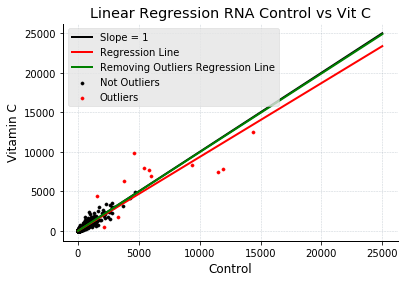

In [96]:
#outliers = ARPE_hMeDIP_outliers["VitC_Average"].values
fig, tmp = plt.subplots()
ax = SC_VitC_RNA_removing_outliers.plot.scatter(y = "VitC_Average", x = "Control_Average", 
                                                ax=tmp, color = 'k', label = "Not Outliers", s = 10)
ax.scatter(y = SC_VitC_RNA_outliers["VitC_Average"], x = SC_VitC_RNA_outliers["Control_Average"], 
           color = 'r', label="Outliers", s = 10)

x_straight = sc.linspace(0, 25000, 10)
y_straight = x_straight # I want this line to be a straight line with a slope of 1

plt.title("Linear Regression RNA Control vs Vit C", color='black')
plt.ylabel("Vitamin C", color='black')
plt.xlabel("Control", color='black')
ax.set_facecolor('white')
ax.tick_params(color='black', labelcolor='black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.grid(color='lightslategray', linestyle='--', linewidth=0.5, alpha=0.4)
plt.tick_params(axis = 'both', which = 'major', labelsize='10')

parameters = linear_model_RNA.params
x = sc.linspace(0, 25000, 10)
y = parameters[0] + parameters[1]*x


outlier_parameters = outliers_removed_model_RNA.params
#x = sc.linspace(0, 350, 10)
outlier_y = outlier_parameters[0] + outlier_parameters[1]*x


plt.plot(x_straight,y_straight,label="Slope = 1", linewidth=2, color='k')
plt.plot(x,y,label="Regression Line", linewidth=2, color='r')
plt.plot(x,outlier_y,label="Removing Outliers Regression Line", linewidth=2, color='g')
plt.legend(loc='upper left')
plt.savefig(Output_Path+"SC_VitC_RNA_Finding_Outliers.png", dpi=300) # size above specified at 10x6
plt.show()


I was surprised to find that removing the outliers shifted the slope almost exactly to a slope of 1. The R2 values were extremely high (91.8% in the outliers removed model). It looks like it normalized well. 

In [97]:
print(len(SC_VitC_RNA_removing_outliers))
print(len(SC_VitC_RNA_first_RCPM_averages))
print(len(SC_VitC_RNA_outliers))

# Difference of 12, which is the number of outliers

32871
32883
12


In [98]:
remove_outliers_RNA = SC_VitC_Raw_RNA_data.drop(SC_VitC_RNA_outliers.index, axis = 0)


In [99]:
total_counts_removing_outliers_RNA = remove_outliers_RNA.sum(axis=0)

In [100]:
total_counts_removing_outliers_RNA

SC_Control_01           2.468742e+07
SC_Control_02           3.051495e+07
SC_Control_03           2.153423e+07
SC_VitC_01              2.432794e+07
SC_VitC_02              2.579432e+07
SC_VitC_03              2.631612e+07
Control_1_first_RCPM    9.200837e+05
Control_2_first_RCPM    9.198652e+05
Control_3_first_RCPM    9.209819e+05
VitC_1_first_RCPM       9.160873e+05
VitC_2_first_RCPM       9.182628e+05
VitC_3_first_RCPM       9.213036e+05
Control_Average         9.203103e+05
VitC_Average            9.185512e+05
dtype: float64

In [101]:
SC_VitC_Raw_RNA_data.head()

,SC_Control_01,SC_Control_02,SC_Control_03,SC_VitC_01,SC_VitC_02,SC_VitC_03,Control_1_first_RCPM,Control_2_first_RCPM,Control_3_first_RCPM,VitC_1_first_RCPM,VitC_2_first_RCPM,VitC_3_first_RCPM,Control_Average,VitC_Average
Ensembl_ID,,,,,,,,,,,,,,
ENSRNOG00000000001,25,21,23,25,33,24,0.931733,0.633040,0.983670,0.941394,1.174781,0.840218,0.849481,0.985464
ENSRNOG00000000007,0,0,0,1,0,1,0.000000,0.000000,0.000000,0.037656,0.000000,0.035009,0.000000,0.024222
ENSRNOG00000000008,104,127,92,203,210,231,3.876010,3.828382,3.934682,7.644121,7.475877,8.087101,3.879691,7.735700
ENSRNOG00000000009,0,0,0,0,0,1,0.000000,0.000000,0.000000,0.000000,0.000000,0.035009,0.000000,0.011670
ENSRNOG00000000010,2,2,1,3,2,5,0.074539,0.060289,0.042768,0.112967,0.071199,0.175045,0.059199,0.119737


In [102]:
SC_VitC_Raw_RNA_data["SC_Control_1_RCPM"] = SC_VitC_Raw_RNA_data["SC_Control_01"]*1000000/total_counts_removing_outliers_RNA[0]
SC_VitC_Raw_RNA_data["SC_Control_2_RCPM"] = SC_VitC_Raw_RNA_data["SC_Control_02"]*1000000/total_counts_removing_outliers_RNA[1]
SC_VitC_Raw_RNA_data["SC_Control_3_RCPM"] = SC_VitC_Raw_RNA_data["SC_Control_03"]*1000000/total_counts_removing_outliers_RNA[2]
SC_VitC_Raw_RNA_data["SC_VitC_1_RCPM"] = SC_VitC_Raw_RNA_data["SC_VitC_01"]*1000000/total_counts_removing_outliers_RNA[3]
SC_VitC_Raw_RNA_data["SC_VitC_2_RCPM"] = SC_VitC_Raw_RNA_data["SC_VitC_02"]*1000000/total_counts_removing_outliers_RNA[4]
SC_VitC_Raw_RNA_data["SC_VitC_3_RCPM"] = SC_VitC_Raw_RNA_data["SC_VitC_03"]*1000000/total_counts_removing_outliers_RNA[5]
SC_VitC_RNA_Corrected_RCPM = SC_VitC_Raw_RNA_data[["SC_Control_1_RCPM", "SC_Control_2_RCPM", "SC_Control_3_RCPM", "SC_VitC_1_RCPM", "SC_VitC_2_RCPM", "SC_VitC_3_RCPM"]]

In [103]:
SC_VitC_RNA_Corrected_RCPM.head()

,SC_Control_1_RCPM,SC_Control_2_RCPM,SC_Control_3_RCPM,SC_VitC_1_RCPM,SC_VitC_2_RCPM,SC_VitC_3_RCPM
Ensembl_ID,,,,,,
ENSRNOG00000000001,1.012661,0.688187,1.068067,1.027625,1.279351,0.911988
ENSRNOG00000000007,0.000000,0.000000,0.000000,0.041105,0.000000,0.038000
ENSRNOG00000000008,4.212671,4.161895,4.272268,8.344315,8.141327,8.777889
ENSRNOG00000000009,0.000000,0.000000,0.000000,0.000000,0.000000,0.038000
ENSRNOG00000000010,0.081013,0.065542,0.046438,0.123315,0.077536,0.189998


In [104]:
SC_VitC_RNA_Corrected_RCPM.to_csv(Output_Path+"SC_VitC_RNA_RCPM_table.csv")

In [105]:
Rat_Genomic_Info_File = pd.read_csv(Input_genomic_info_file, sep = ",", index_col = 0 )


In [106]:
Rat_Genomic_Info_File.dtypes # It looks like I don't need to specify the types because the lengths and positions went in as int

Gene_Name             object
Location              object
Sense                 object
Gene_Biotype          object
transcript_id         object
Chr                   object
Start                  int64
Stop                   int64
Length                 int64
Exon Length            int64
Intron Length          int64
Gene_ID               object
gene_version           int64
transcript_version     int64
gene_name             object
gene_source           object
gene_biotype          object
transcript_name       object
transcript_source     object
transcript_biotype    object
dtype: object

In [107]:
Rat_Genomic_Info_File.head()

,Gene_Name,Location,Sense,Gene_Biotype,transcript_id,Chr,Start,Stop,Length,Exon Length,Intron Length,Gene_ID,gene_version,transcript_version,gene_name,gene_source,gene_biotype,transcript_name,transcript_source,transcript_biotype
Ensembl_ID,,,,,,,,,,,,,,,,,,,,
ENSRNOG00000000001,AABR07013255.1,chr2:230660664-230662084,+,pseudogene,ENSRNOT00000055633,2,230660664,230662084,1421,1416,5,ENSRNOG00000000001,5,2,AABR07013255.1,ensembl,pseudogene,AABR07013255.1-201,ensembl,pseudogene
ENSRNOG00000000007,Gad1,chr3:56861396-56902157,+,protein_coding,ENSRNOT00000087712,3,56862691,56902137,39447,3381,36066,ENSRNOG00000000007,7,1,Gad1,ensembl,protein_coding,Gad1-204,ensembl,protein_coding
ENSRNOG00000000008,Alx4,chr3:82548959-82585531,+,protein_coding,ENSRNOT00000000009,3,82548959,82585531,36573,1747,34826,ENSRNOG00000000008,7,5,Alx4,ensembl,protein_coding,Alx4-201,ensembl,protein_coding
ENSRNOG00000000009,Tmco5b,chr3:104749051-104765436,+,protein_coding,ENSRNOT00000000010,3,104749051,104765436,16386,1361,15025,ENSRNOG00000000009,5,5,Tmco5b,ensembl,protein_coding,Tmco5b-201,ensembl,protein_coding
ENSRNOG00000000010,Cbln1,chr19:20607507-20611316,+,protein_coding,ENSRNOT00000000011,19,20607507,20611316,3810,2444,1366,ENSRNOG00000000010,5,5,Cbln1,ensembl,protein_coding,Cbln1-201,ensembl,protein_coding


In [108]:
SC_VitC_RNA_Corrected_RCPM = SC_VitC_RNA_Corrected_RCPM.join(Rat_Genomic_Info_File)

In [109]:
SC_VitC_RNA_Corrected_RCPM.head()

,SC_Control_1_RCPM,SC_Control_2_RCPM,SC_Control_3_RCPM,SC_VitC_1_RCPM,SC_VitC_2_RCPM,SC_VitC_3_RCPM,Gene_Name,Location,Sense,Gene_Biotype,...,Intron Length,Gene_ID,gene_version,transcript_version,gene_name,gene_source,gene_biotype,transcript_name,transcript_source,transcript_biotype
Ensembl_ID,,,,,,,,,,,,,,,,,,,,,
ENSRNOG00000000001,1.012661,0.688187,1.068067,1.027625,1.279351,0.911988,AABR07013255.1,chr2:230660664-230662084,+,pseudogene,...,5,ENSRNOG00000000001,5,2,AABR07013255.1,ensembl,pseudogene,AABR07013255.1-201,ensembl,pseudogene
ENSRNOG00000000007,0.000000,0.000000,0.000000,0.041105,0.000000,0.038000,Gad1,chr3:56861396-56902157,+,protein_coding,...,36066,ENSRNOG00000000007,7,1,Gad1,ensembl,protein_coding,Gad1-204,ensembl,protein_coding
ENSRNOG00000000008,4.212671,4.161895,4.272268,8.344315,8.141327,8.777889,Alx4,chr3:82548959-82585531,+,protein_coding,...,34826,ENSRNOG00000000008,7,5,Alx4,ensembl,protein_coding,Alx4-201,ensembl,protein_coding
ENSRNOG00000000009,0.000000,0.000000,0.000000,0.000000,0.000000,0.038000,Tmco5b,chr3:104749051-104765436,+,protein_coding,...,15025,ENSRNOG00000000009,5,5,Tmco5b,ensembl,protein_coding,Tmco5b-201,ensembl,protein_coding
ENSRNOG00000000010,0.081013,0.065542,0.046438,0.123315,0.077536,0.189998,Cbln1,chr19:20607507-20611316,+,protein_coding,...,1366,ENSRNOG00000000010,5,5,Cbln1,ensembl,protein_coding,Cbln1-201,ensembl,protein_coding


In [110]:
SC_VitC_RNA_Corrected_RCPM["SC_Control_1_FPKM"]= SC_VitC_RNA_Corrected_RCPM["SC_Control_1_RCPM"]*1000/SC_VitC_RNA_Corrected_RCPM["Exon Length"]
SC_VitC_RNA_Corrected_RCPM["SC_Control_2_FPKM"]= SC_VitC_RNA_Corrected_RCPM["SC_Control_2_RCPM"]*1000/SC_VitC_RNA_Corrected_RCPM["Exon Length"]
SC_VitC_RNA_Corrected_RCPM["SC_Control_3_FPKM"]= SC_VitC_RNA_Corrected_RCPM["SC_Control_3_RCPM"]*1000/SC_VitC_RNA_Corrected_RCPM["Exon Length"]

SC_VitC_RNA_Corrected_RCPM["SC_VitC_1_FPKM"]= SC_VitC_RNA_Corrected_RCPM["SC_VitC_1_RCPM"]*1000/SC_VitC_RNA_Corrected_RCPM["Exon Length"]
SC_VitC_RNA_Corrected_RCPM["SC_VitC_2_FPKM"]= SC_VitC_RNA_Corrected_RCPM["SC_VitC_2_RCPM"]*1000/SC_VitC_RNA_Corrected_RCPM["Exon Length"]
SC_VitC_RNA_Corrected_RCPM["SC_VitC_3_FPKM"]= SC_VitC_RNA_Corrected_RCPM["SC_VitC_3_RCPM"]*1000/SC_VitC_RNA_Corrected_RCPM["Exon Length"]


In [111]:
SC_VitC_RNA_FPKM_table = SC_VitC_RNA_Corrected_RCPM[["SC_Control_1_FPKM", "SC_Control_2_FPKM", "SC_Control_3_FPKM", "SC_VitC_1_FPKM", "SC_VitC_2_FPKM", "SC_VitC_3_FPKM"]]


In [112]:
SC_VitC_RNA_FPKM_table.head()

,SC_Control_1_FPKM,SC_Control_2_FPKM,SC_Control_3_FPKM,SC_VitC_1_FPKM,SC_VitC_2_FPKM,SC_VitC_3_FPKM
Ensembl_ID,,,,,,
ENSRNOG00000000001,0.715156,0.486008,0.754285,0.725724,0.903497,0.644060
ENSRNOG00000000007,0.000000,0.000000,0.000000,0.012158,0.000000,0.011239
ENSRNOG00000000008,2.411374,2.382310,2.445488,4.776368,4.660176,5.024550
ENSRNOG00000000009,0.000000,0.000000,0.000000,0.000000,0.000000,0.027920
ENSRNOG00000000010,0.033148,0.026817,0.019001,0.050456,0.031725,0.077740


In [113]:
#SC_VitC_RNA_FPKM_table.to_csv(Output_Path+"SC_VitC_RNA_FPKM_table.csv")
#SC_VitC_RNA_FPKM_table.to_pickle(Output_Path+"SC_VitC_RNA_FPKM_table.pkl")


Now I have the FPKM table for the RNA. Next I need to read in the statistical files (edgeR and DESeq2) and calculate fold changes to determine which direction each gene goes. When I did this for the hMeDIP, none of them had values of 0 so I didn't need to worry about dividing by infinity. For this one, I needed to make up a lambda function for an if statement if the values were below 0.1 for both VitC and Control.

In [114]:
SC_VitC_RNA_FPKM_table["Control_Average_FPKM"] = SC_VitC_RNA_FPKM_table[["SC_Control_1_FPKM", "SC_Control_2_FPKM", "SC_Control_2_FPKM"]].mean(axis=1)
SC_VitC_RNA_FPKM_table["VitC_Average_FPKM"] = SC_VitC_RNA_FPKM_table[["SC_VitC_1_FPKM", "SC_VitC_2_FPKM", "SC_VitC_3_FPKM"]].mean(axis=1)
SC_VitC_RNA_FPKM_table["Fold_Change"] =  SC_VitC_RNA_FPKM_table.apply(lambda x: 1 if max(x["VitC_Average_FPKM"],x["Control_Average_FPKM"]) < 0.1 else (x["VitC_Average_FPKM"]/x["Control_Average_FPKM"]), axis = 1)


SC_VitC_RNA_FPKM_table["Log2FC"] = np.log2(SC_VitC_RNA_FPKM_table["Fold_Change"])
# All 4 of these return warnings, if you have run this before because you are replacing the old values with new ones (which are the same as the old)

/Users/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.
/Users/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/Users/david/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: divide by zero encountered in double_scalars
  This is separate from the ipykernel package so we can avoid doing imports until
/Users/david/anaconda3/lib/python3

In [115]:
SC_VitC_RNA_FPKM_table.head()

,SC_Control_1_FPKM,SC_Control_2_FPKM,SC_Control_3_FPKM,SC_VitC_1_FPKM,SC_VitC_2_FPKM,SC_VitC_3_FPKM,Control_Average_FPKM,VitC_Average_FPKM,Fold_Change,Log2FC
Ensembl_ID,,,,,,,,,,
ENSRNOG00000000001,0.715156,0.486008,0.754285,0.725724,0.903497,0.644060,0.562391,0.757760,1.347391,0.430168
ENSRNOG00000000007,0.000000,0.000000,0.000000,0.012158,0.000000,0.011239,0.000000,0.007799,1.000000,0.000000
ENSRNOG00000000008,2.411374,2.382310,2.445488,4.776368,4.660176,5.024550,2.391998,4.820365,2.015204,1.010926
ENSRNOG00000000009,0.000000,0.000000,0.000000,0.000000,0.000000,0.027920,0.000000,0.009307,1.000000,0.000000
ENSRNOG00000000010,0.033148,0.026817,0.019001,0.050456,0.031725,0.077740,0.028927,0.053307,1.000000,0.000000


In [116]:
SC_VitC_RNA_edgeR = pd.read_csv(Input_RNA_edgeR, sep = ",", index_col=0) 
SC_VitC_RNA_edgeR = SC_VitC_RNA_edgeR.drop(['logFC', 'logCPM', 'LR', 'PValue'], axis = 1)
SC_VitC_RNA_edgeR.columns=["edgeR"]

SC_VitC_RNA_DESeq2 = pd.read_csv(Input_RNA_DESeq2, sep = ",", index_col=0)
SC_VitC_RNA_DESeq2 = SC_VitC_RNA_DESeq2.drop(['baseMean', 'log2FoldChange', 'lfcSE', 'stat', 'pvalue'], axis = 1)
SC_VitC_RNA_DESeq2.columns = ["DESeq2"]
SC_VitC_RNA_DESeq2 = SC_VitC_RNA_DESeq2.fillna(1)

In [117]:
SC_VitC_RNA_edgeR.head()

,edgeR
Gene_ID,
ENSRNOG00000008000,6.970000e-199
ENSRNOG00000056714,1.350000e-155
ENSRNOG00000007159,8.870000e-153
ENSRNOG00000058003,2.130000e-139
ENSRNOG00000024082,4.760000e-116


In [118]:
SC_VitC_RNA_DESeq2.head()

,DESeq2
ENSRNOG00000008000,9.380000e-261
ENSRNOG00000056714,1.560000e-232
ENSRNOG00000005580,1.500000e-189
ENSRNOG00000010286,2.070000e-182
ENSRNOG00000020060,3.160000e-166


In [119]:
SC_VitC_RNA_FPKM_table = SC_VitC_RNA_FPKM_table.join([SC_VitC_RNA_edgeR, SC_VitC_RNA_DESeq2])

In [120]:
SC_VitC_RNA_FPKM_table.head(15)

,SC_Control_1_FPKM,SC_Control_2_FPKM,SC_Control_3_FPKM,SC_VitC_1_FPKM,SC_VitC_2_FPKM,SC_VitC_3_FPKM,Control_Average_FPKM,VitC_Average_FPKM,Fold_Change,Log2FC,edgeR,DESeq2
Ensembl_ID,,,,,,,,,,,,
ENSRNOG00000000001,0.715156,0.486008,0.754285,0.725724,0.903497,0.644060,0.562391,0.757760,1.347391,0.430168,7.507860e-01,6.209275e-01
ENSRNOG00000000007,0.000000,0.000000,0.000000,0.012158,0.000000,0.011239,0.000000,0.007799,1.000000,0.000000,3.898456e-01,1.000000e+00
ENSRNOG00000000008,2.411374,2.382310,2.445488,4.776368,4.660176,5.024550,2.391998,4.820365,2.015204,1.010926,3.470000e-12,1.440000e-09
ENSRNOG00000000009,0.000000,0.000000,0.000000,0.000000,0.000000,0.027920,0.000000,0.009307,1.000000,0.000000,6.624017e-01,1.000000e+00
ENSRNOG00000000010,0.033148,0.026817,0.019001,0.050456,0.031725,0.077740,0.028927,0.053307,1.000000,0.000000,5.854191e-01,1.000000e+00
ENSRNOG00000000012,0.000000,0.000000,0.000000,0.000000,0.039042,0.000000,0.000000,0.013014,1.000000,0.000000,6.624017e-01,1.000000e+00
ENSRNOG00000000017,0.664559,0.844873,0.906986,0.706492,1.635534,1.157798,0.784768,1.166608,1.486564,0.571982,2.525549e-01,2.469673e-01
ENSRNOG00000000021,12.793288,13.681820,14.473083,11.817687,14.764231,14.123155,13.385642,13.568358,1.013650,0.019560,1.000000e+00,7.674736e-01
ENSRNOG00000000024,15.943218,15.212822,15.348053,13.004972,14.711482,14.026188,15.456287,13.914214,0.900230,-0.151634,9.658437e-01,6.204969e-01


In [121]:
SC_VitC_RNA_FPKM_table.loc["ENSRNOG00000008000"] # This went in correctly

SC_Control_1_FPKM        4.072902e+01
SC_Control_2_FPKM        4.275939e+01
SC_Control_3_FPKM        4.509479e+01
SC_VitC_1_FPKM           4.100990e+00
SC_VitC_2_FPKM           3.722108e+00
SC_VitC_3_FPKM           4.241705e+00
Control_Average_FPKM     4.208260e+01
VitC_Average_FPKM        4.021601e+00
Fold_Change              9.556447e-02
Log2FC                  -3.387382e+00
edgeR                   6.970000e-199
DESeq2                  9.380000e-261
Name: ENSRNOG00000008000, dtype: float64

In [122]:
# This definition will mistakenly put "downregulated" for ones with good P-values by both but a fold change of 1
# These ones will be filtered out in the next step, finding limit of detection
def direction(row):
    if row["edgeR"] < 0.05 and row["DESeq2"] < 0.05:
        if row["Log2FC"] > 0:
            return "Upregulated"
        else:
            return "Downregulated"
    else:
        return "Nondifferential"

SC_VitC_RNA_FPKM_table["Change"] =  SC_VitC_RNA_FPKM_table.apply(direction, axis = 1)
# I figured out how to make it faster :)

In [123]:
SC_VitC_RNA_FPKM_table.head()

,SC_Control_1_FPKM,SC_Control_2_FPKM,SC_Control_3_FPKM,SC_VitC_1_FPKM,SC_VitC_2_FPKM,SC_VitC_3_FPKM,Control_Average_FPKM,VitC_Average_FPKM,Fold_Change,Log2FC,edgeR,DESeq2,Change
Ensembl_ID,,,,,,,,,,,,,
ENSRNOG00000000001,0.715156,0.486008,0.754285,0.725724,0.903497,0.644060,0.562391,0.757760,1.347391,0.430168,7.507860e-01,6.209275e-01,Nondifferential
ENSRNOG00000000007,0.000000,0.000000,0.000000,0.012158,0.000000,0.011239,0.000000,0.007799,1.000000,0.000000,3.898456e-01,1.000000e+00,Nondifferential
ENSRNOG00000000008,2.411374,2.382310,2.445488,4.776368,4.660176,5.024550,2.391998,4.820365,2.015204,1.010926,3.470000e-12,1.440000e-09,Upregulated
ENSRNOG00000000009,0.000000,0.000000,0.000000,0.000000,0.000000,0.027920,0.000000,0.009307,1.000000,0.000000,6.624017e-01,1.000000e+00,Nondifferential
ENSRNOG00000000010,0.033148,0.026817,0.019001,0.050456,0.031725,0.077740,0.028927,0.053307,1.000000,0.000000,5.854191e-01,1.000000e+00,Nondifferential


In [124]:
SC_VitC_RNA_FPKM_table.to_csv(Output_Path+"SC_VitC_RNA_FPKM_table.csv")
SC_VitC_RNA_FPKM_table.to_pickle(Output_Path+"SC_VitC_RNA_FPKM_table.pkl")

Now I have the FPKM table calculated out and I have determined which ones go up and down, but I have not filtered out genes that are really lowly expressed. The next step is to take those out because they will not add information to our analysis, but just add noise.

Now I am going to calculate the FPKM values for the genomic input samples. I am going to see if I can use these to determine a cutoff LOD for the RNA. Luckily, I don't need to worry about outliers for this one because it is genomic input and I want to include those ones if there is something funky because it might transfer across the other sequencing files too.

In [125]:
SC_VitC_genomic_input_raw = pd.read_csv(Input_Genomic_Input_Counts_File, sep = "\t", index_col = 0)

In [126]:
SC_VitC_genomic_input_raw.head()

,SC_Control_1_IN,SC_Control_2_IN,SC_Control_3_IN,SC_VitC_1_IN,SC_VitC_2_IN,SC_VitC_3_IN
Peak_Name,,,,,,
"SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merged_peak_92032",29,32,29,25,35,35
"SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merged_peak_92041",17,23,30,18,21,28
SC_Control_IP_Merged_peak_100020,24,26,29,21,33,24
SC_Control_IP_Merged_peak_100028,21,12,20,15,17,15
SC_Control_IP_Merged_peak_10003,28,17,27,25,30,25


In [127]:
total_counts_SC_VitC_genomic_input = SC_VitC_genomic_input_raw.sum(axis=0)

In [128]:
total_counts_SC_VitC_genomic_input

SC_Control_1_IN    100915341
SC_Control_2_IN     83233328
SC_Control_3_IN    111336681
SC_VitC_1_IN        86173506
SC_VitC_2_IN       103924317
SC_VitC_3_IN       102885634
dtype: int64

In [129]:
SC_VitC_genomic_input_raw["SC_Control_1_IN_RCPM"] = SC_VitC_genomic_input_raw["SC_Control_1_IN"]*1000000/total_counts_SC_VitC_genomic_input[0]
SC_VitC_genomic_input_raw["SC_Control_2_IN_RCPM"] = SC_VitC_genomic_input_raw["SC_Control_2_IN"]*1000000/total_counts_SC_VitC_genomic_input[1]
SC_VitC_genomic_input_raw["SC_Control_3_IN_RCPM"] = SC_VitC_genomic_input_raw["SC_Control_3_IN"]*1000000/total_counts_SC_VitC_genomic_input[2]


SC_VitC_genomic_input_raw["SC_VitC_1_IN_RCPM"] = SC_VitC_genomic_input_raw["SC_VitC_1_IN"]*1000000/total_counts_SC_VitC_genomic_input[3]
SC_VitC_genomic_input_raw["SC_VitC_2_IN_RCPM"] = SC_VitC_genomic_input_raw["SC_VitC_2_IN"]*1000000/total_counts_SC_VitC_genomic_input[4]
SC_VitC_genomic_input_raw["SC_VitC_3_IN_RCPM"] = SC_VitC_genomic_input_raw["SC_VitC_3_IN"]*1000000/total_counts_SC_VitC_genomic_input[5]


In [130]:
SC_VitC_genomic_input_rcpm = SC_VitC_genomic_input_raw[["SC_Control_1_IN_RCPM", "SC_Control_2_IN_RCPM", "SC_Control_3_IN_RCPM", "SC_VitC_1_IN_RCPM", "SC_VitC_2_IN_RCPM", "SC_VitC_3_IN_RCPM"]].drop(columns_added_by_htseq, axis = 0)

In [131]:
SC_VitC_genomic_input_rcpm.tail()


,SC_Control_1_IN_RCPM,SC_Control_2_IN_RCPM,SC_Control_3_IN_RCPM,SC_VitC_1_IN_RCPM,SC_VitC_2_IN_RCPM,SC_VitC_3_IN_RCPM
Peak_Name,,,,,,
"SC_LAA_IP_Merged_peak_99980,SC_Control_IP_Merged_peak_108098,SC_Control_IP_Merged_peak_108099",0.822472,0.901081,0.934104,0.997987,0.740924,0.923355
SC_LAA_IP_Merged_peak_99990,0.297279,0.276332,0.278435,0.197276,0.240560,0.184671
SC_LAA_IP_Merged_peak_99994,0.208095,0.192231,0.287417,0.220485,0.211693,0.242988
SC_LAA_IP_Merged_peak_99995,0.267551,0.384461,0.449088,0.185672,0.346406,0.281866
SC_LAA_IP_Merged_peak_99999,0.188277,0.228274,0.233526,0.243694,0.153958,0.291586


In [132]:
SC_VitC_genomic_input_rcpm.to_csv(Output_Path+"SC_VitC_Genomic_Input_RCPM_table.csv")

In [133]:
SC_VitC_hMeDIP_bed = pd.read_csv(Input_bed_file, sep = "\t", index_col = 3) 
SC_VitC_hMeDIP_bed["Width"] = (SC_VitC_hMeDIP_bed["Stop"] - SC_VitC_hMeDIP_bed["Start"] + 1)

In [134]:
SC_VitC_hMeDIP_bed.head()

,Chr,Start,Stop,Width
Peak_Name,,,,
SC_Control_IP_Merged_peak_3,1,50022,50495,474
SC_Control_IP_Merged_peak_4,1,110730,111377,648
SC_Control_IP_Merged_peak_17,1,562156,562456,301
SC_Control_IP_Merged_peak_23,1,759781,760211,431
SC_Control_IP_Merged_peak_33,1,1227704,1228255,552


In [135]:
SC_VitC_genomic_input_rcpm = SC_VitC_genomic_input_rcpm.join(SC_VitC_hMeDIP_bed)

In [136]:
SC_VitC_genomic_input_rcpm["SC_Control_1_IN_FPKM"]= SC_VitC_genomic_input_rcpm["SC_Control_1_IN_RCPM"]*1000/SC_VitC_genomic_input_rcpm["Width"]
SC_VitC_genomic_input_rcpm["SC_Control_2_IN_FPKM"]= SC_VitC_genomic_input_rcpm["SC_Control_2_IN_RCPM"]*1000/SC_VitC_genomic_input_rcpm["Width"]
SC_VitC_genomic_input_rcpm["SC_Control_3_IN_FPKM"]= SC_VitC_genomic_input_rcpm["SC_Control_3_IN_RCPM"]*1000/SC_VitC_genomic_input_rcpm["Width"]

SC_VitC_genomic_input_rcpm["SC_VitC_1_IN_FPKM"]= SC_VitC_genomic_input_rcpm["SC_VitC_1_IN_RCPM"]*1000/SC_VitC_genomic_input_rcpm["Width"]
SC_VitC_genomic_input_rcpm["SC_VitC_2_IN_FPKM"]= SC_VitC_genomic_input_rcpm["SC_VitC_2_IN_RCPM"]*1000/SC_VitC_genomic_input_rcpm["Width"]
SC_VitC_genomic_input_rcpm["SC_VitC_3_IN_FPKM"]= SC_VitC_genomic_input_rcpm["SC_VitC_3_IN_RCPM"]*1000/SC_VitC_genomic_input_rcpm["Width"]


In [137]:
SC_VitC_genomic_input_rcpm.head()

,SC_Control_1_IN_RCPM,SC_Control_2_IN_RCPM,SC_Control_3_IN_RCPM,SC_VitC_1_IN_RCPM,SC_VitC_2_IN_RCPM,SC_VitC_3_IN_RCPM,Chr,Start,Stop,Width,SC_Control_1_IN_FPKM,SC_Control_2_IN_FPKM,SC_Control_3_IN_FPKM,SC_VitC_1_IN_FPKM,SC_VitC_2_IN_FPKM,SC_VitC_3_IN_FPKM
Peak_Name,,,,,,,,,,,,,,,,
"SC_Control_IP_Merged_peak_100000,SC_LAA_IP_Merged_peak_92032",0.287370,0.384461,0.260471,0.290112,0.336784,0.340184,11,58427350,58428140,791,0.363299,0.486045,0.329294,0.366767,0.425769,0.430068
"SC_Control_IP_Merged_peak_100011,SC_LAA_IP_Merged_peak_92041",0.168458,0.276332,0.269453,0.208881,0.202070,0.272147,11,58467708,58468197,490,0.343792,0.563942,0.549904,0.426288,0.412388,0.555402
SC_Control_IP_Merged_peak_100020,0.237823,0.312375,0.260471,0.243694,0.317539,0.233269,11,58509719,58510097,379,0.627502,0.824208,0.687259,0.642993,0.837833,0.615485
SC_Control_IP_Merged_peak_100028,0.208095,0.144173,0.179635,0.174067,0.163581,0.145793,11,58518547,58518878,332,0.626793,0.434256,0.541070,0.524299,0.492713,0.439135
SC_Control_IP_Merged_peak_10003,0.277460,0.204245,0.242508,0.290112,0.288672,0.242988,1,48456350,48456761,412,0.673447,0.495741,0.588611,0.704156,0.700659,0.589777


In [138]:
SC_VitC_genomic_input_rcpm.describe()

,SC_Control_1_IN_RCPM,SC_Control_2_IN_RCPM,SC_Control_3_IN_RCPM,SC_VitC_1_IN_RCPM,SC_VitC_2_IN_RCPM,SC_VitC_3_IN_RCPM,Start,Stop,Width,SC_Control_1_IN_FPKM,SC_Control_2_IN_FPKM,SC_Control_3_IN_FPKM,SC_VitC_1_IN_FPKM,SC_VitC_2_IN_FPKM,SC_VitC_3_IN_FPKM
count,215951.000000,215951.000000,215951.000000,215951.000000,215951.000000,215951.000000,2.159510e+05,2.159510e+05,215951.000000,215951.000000,215951.000000,215951.000000,215951.000000,215951.000000,215951.000000
mean,0.393217,0.400663,0.395996,0.397272,0.397458,0.390218,8.314439e+07,8.314520e+07,819.269418,0.495449,0.504540,0.500739,0.503088,0.503577,0.494569
std,0.264691,0.271959,0.264080,0.266468,0.264857,0.258963,6.182687e+07,6.182687e+07,578.368034,0.120438,0.130183,0.123059,0.135358,0.128446,0.125916
min,0.009909,0.012014,0.017964,0.011604,0.028867,0.009720,5.500000e+01,5.080000e+02,257.000000,0.034648,0.038632,0.057027,0.031279,0.077600,0.028503
25%,0.227914,0.228274,0.233526,0.232090,0.230937,0.233269,3.536651e+07,3.536715e+07,455.000000,0.417234,0.420257,0.420473,0.415039,0.419769,0.412598
50%,0.317097,0.324389,0.323344,0.324926,0.327161,0.320744,7.017918e+07,7.017961e+07,640.000000,0.479482,0.487071,0.482167,0.482607,0.483316,0.475515
75%,0.475646,0.480577,0.476034,0.475784,0.471497,0.466537,1.178669e+08,1.178676e+08,977.000000,0.556702,0.570685,0.561360,0.569090,0.566023,0.555771
max,7.986893,7.821386,7.859045,7.798220,7.823001,8.222722,2.825860e+08,2.825864e+08,18486.000000,4.886308,5.945065,4.769627,5.722216,4.993687,5.127890


In [139]:
SC_VitC_Genomic_Input_FPKM_table = SC_VitC_genomic_input_rcpm[["SC_Control_1_IN_FPKM", "SC_Control_2_IN_FPKM", "SC_Control_3_IN_FPKM", 
                                                               "SC_VitC_1_IN_FPKM", "SC_VitC_2_IN_FPKM", "SC_VitC_3_IN_FPKM"]]
SC_VitC_Genomic_Input_FPKM_table.to_csv(Output_Path+"SC_VitC_Genomic_Input_FPKM_table.csv")
#I am not going to make a pickle file for this one because I don't think we are likely to use it in future analysis

Well, calculating the FPKM for the genomic input without removing outliers was much less painful. Now I can move on to a density plot with genomic input (should have no bias to any region) and RNA. 

The genomic input is just sheared DNA with no form of pull-down. This is meant to show us what kind of coverage you get in each genomic region just by chance of the DNA-sequence. These were generated for calling peaks in the hMeDIP, but can be used her to show what we get if we are just sequencing noise. 

I am going to look at a density plot of the genomic input samples. These are just noise, so if we use a cutoff for limit of detection below the top expressed of these, those ones would essentially be "false positives" as to limit of detection.

When I look at the denisty plot for the RNA, those are annotated genes. In other words, those should be annotated as "above limit of detection", so if I use a cutoff above the most lowly expressed gene, this gives "false negatives" as to the limit of detection. 

I am going to chart both the genomic input samples and the RNA samples on the same graph. Where the two overlap, there will be a minimum between the "false positives" and the "false negatives". This value gives us our limit of detection. (See Trapnell et al. 2012 Nature Protocols)



First I need to take the log10 of each value. It makes it easier to visualize. 

In [140]:

SC_VitC_Genomic_Input_FPKM_table = pd.read_csv(Output_Path+"SC_VitC_Genomic_Input_FPKM_table.csv", sep = ",", index_col = 0)
SC_VitC_RNA_FPKM_table = pd.read_pickle(Output_Path+"SC_VitC_RNA_FPKM_table.pkl")


In [141]:
SC_VitC_RNA_FPKM_table.head()

,SC_Control_1_FPKM,SC_Control_2_FPKM,SC_Control_3_FPKM,SC_VitC_1_FPKM,SC_VitC_2_FPKM,SC_VitC_3_FPKM,Control_Average_FPKM,VitC_Average_FPKM,Fold_Change,Log2FC,edgeR,DESeq2,Change
Ensembl_ID,,,,,,,,,,,,,
ENSRNOG00000000001,0.715156,0.486008,0.754285,0.725724,0.903497,0.644060,0.562391,0.757760,1.347391,0.430168,7.507860e-01,6.209275e-01,Nondifferential
ENSRNOG00000000007,0.000000,0.000000,0.000000,0.012158,0.000000,0.011239,0.000000,0.007799,1.000000,0.000000,3.898456e-01,1.000000e+00,Nondifferential
ENSRNOG00000000008,2.411374,2.382310,2.445488,4.776368,4.660176,5.024550,2.391998,4.820365,2.015204,1.010926,3.470000e-12,1.440000e-09,Upregulated
ENSRNOG00000000009,0.000000,0.000000,0.000000,0.000000,0.000000,0.027920,0.000000,0.009307,1.000000,0.000000,6.624017e-01,1.000000e+00,Nondifferential
ENSRNOG00000000010,0.033148,0.026817,0.019001,0.050456,0.031725,0.077740,0.028927,0.053307,1.000000,0.000000,5.854191e-01,1.000000e+00,Nondifferential


In [142]:
control_1_RNA = []
for i in SC_VitC_RNA_FPKM_table["SC_Control_1_FPKM"].values:
    if i > 0.001:
        control_1_RNA.append(np.log10(i))

control_2_RNA = []
for i in SC_VitC_RNA_FPKM_table["SC_Control_2_FPKM"].values:
    if i > 0.001:
        control_2_RNA.append(np.log10(i))

control_3_RNA = []
for i in SC_VitC_RNA_FPKM_table["SC_Control_3_FPKM"].values:
    if i > 0.001:
        control_3_RNA.append(np.log10(i))

vitc_1_RNA = []
for i in SC_VitC_RNA_FPKM_table["SC_VitC_1_FPKM"].values:
    if i > 0.001:
        vitc_1_RNA.append(np.log10(i))

vitc_2_RNA = []
for i in SC_VitC_RNA_FPKM_table["SC_VitC_2_FPKM"].values:
    if i > 0.001:
        vitc_2_RNA.append(np.log10(i))

vitc_3_RNA = []
for i in SC_VitC_RNA_FPKM_table["SC_VitC_3_FPKM"].values:
    if i > 0.001:
        vitc_3_RNA.append(np.log10(i))
        


control_1_INPUT = []
for i in SC_VitC_Genomic_Input_FPKM_table["SC_Control_1_IN_FPKM"].values:
    if i > 0.001:
        control_1_INPUT.append(np.log10(i))
        
control_2_INPUT = []
for i in SC_VitC_Genomic_Input_FPKM_table["SC_Control_2_IN_FPKM"].values:
    if i > 0.001:
        control_2_INPUT.append(np.log10(i))
        
control_3_INPUT = []
for i in SC_VitC_Genomic_Input_FPKM_table["SC_Control_3_IN_FPKM"].values:
    if i > 0.001:
        control_3_INPUT.append(np.log10(i))
        
        
vitc_1_INPUT = []
for i in SC_VitC_Genomic_Input_FPKM_table["SC_VitC_1_IN_FPKM"].values:
    if i > 0.001:
        vitc_1_INPUT.append(np.log10(i))
        
vitc_2_INPUT = []
for i in SC_VitC_Genomic_Input_FPKM_table["SC_VitC_2_IN_FPKM"].values:
    if i > 0.001:
        vitc_2_INPUT.append(np.log10(i))

vitc_3_INPUT = []
for i in SC_VitC_Genomic_Input_FPKM_table["SC_VitC_3_IN_FPKM"].values:
    if i > 0.001:
        vitc_3_INPUT.append(np.log10(i))
        

In [143]:
print(len(control_1_RNA))
print(len(control_2_RNA))
print(len(control_3_RNA))
print(len(vitc_1_RNA))
print(len(vitc_2_RNA))
print(len(vitc_3_RNA))
print(len(control_1_INPUT))
print(len(control_2_INPUT))
print(len(control_3_INPUT))
print(len(vitc_1_INPUT))
print(len(vitc_2_INPUT))
print(len(vitc_3_INPUT))
# The lengths are not identical for any of them indicating I didn't accidentally copy over any of them

16724
16993
16259
17229
17040
17347
215951
215951
215951
215951
215951
215951


In [144]:
import itertools

In [145]:
log_tables_list = [control_1_RNA, control_2_RNA, control_3_RNA, vitc_1_RNA, vitc_2_RNA, vitc_3_RNA,
                   control_1_INPUT, control_2_INPUT, control_3_INPUT, vitc_1_INPUT, vitc_2_INPUT, vitc_3_INPUT]
table_of_logs = pd.DataFrame((_ for _ in itertools.zip_longest(*log_tables_list)), columns=["control_1_RNA", "control_2_RNA", "control_3_RNA", 
                                                                                                "vitc_1_RNA", "vitc_2_RNA", "vitc_3_RNA", 
                                                                                                "control_1_INPUT", "control_2_INPUT", "control_3_INPUT",
                                                                                            "vitc_1_INPUT", "vitc_2_INPUT", "vitc_3_INPUT"])

In [146]:
table_of_logs.head()

,control_1_RNA,control_2_RNA,control_3_RNA,vitc_1_RNA,vitc_2_RNA,vitc_3_RNA,control_1_INPUT,control_2_INPUT,control_3_INPUT,vitc_1_INPUT,vitc_2_INPUT,vitc_3_INPUT
0,-0.145599,-0.313357,-0.122465,-0.139229,-0.044073,-0.191074,-0.439736,-0.313324,-0.482417,-0.435610,-0.370826,-0.366463
1,0.382265,0.376998,0.388366,-1.915151,0.668402,-1.949267,-0.463704,-0.248766,-0.259713,-0.370297,-0.384694,-0.255393
2,-1.479547,-1.571584,-1.721231,0.679098,-1.498595,0.701097,-0.202385,-0.083963,-0.162879,-0.191794,-0.076842,-0.210783
3,-0.177466,-0.073209,-0.042399,-1.297085,-1.408473,-1.554080,-0.202876,-0.362254,-0.266746,-0.280421,-0.307406,-0.357402
4,1.106982,1.136144,1.160561,-0.150893,0.213660,-1.109353,-0.171696,-0.304746,-0.230172,-0.152331,-0.154493,-0.229312


In [147]:
import seaborn as sns

/Users/david/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/Users/david/anaconda3/lib/python3.7/site-packages/statsmodels/nonparametric/kde.py:448: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
/Users/david/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


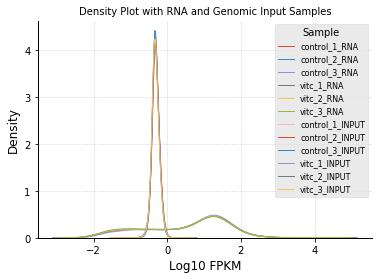

In [148]:
sample_names = ["control_1_RNA", "control_2_RNA", "control_3_RNA", "vitc_1_RNA", "vitc_2_RNA", "vitc_3_RNA", "control_1_INPUT", "control_2_INPUT", "control_3_INPUT", "vitc_1_INPUT", "vitc_2_INPUT", "vitc_3_INPUT"]
fig, ax = plt.subplots()##
plt.title("Density Plot with RNA and Genomic Input Samples", color='black', size = 10)
plt.ylabel("Density", color='black')
plt.xlabel("Log10 FPKM", color='black')
ax.set_facecolor('white')
ax.set_facecolor('white')
ax.tick_params(color='black', labelcolor='black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.grid(color='lightslategray', linestyle='--', linewidth=0.5, alpha=0.4)
plt.tick_params(axis = 'both', which = 'major', labelsize='10')

for sample in sample_names:
    # Subset to the airline
    subset = table_of_logs[[sample]].values
    
    # Draw the density plot
    sns.distplot(subset, hist = False, kde = True, 
                 kde_kws = {'linewidth': 1}, label = sample)


plt.legend(prop={'size': 8}, title = 'Sample')
#plt.title('Density Plot with RNA and Genomic Input Samples')
#plt.xlabel('Log10 FPKM')
#plt.ylabel('Density')
plt.savefig(Output_Path+"SC_VitC_RNA_LOD_Chart.png", dpi=300) # size above specified at 10x6


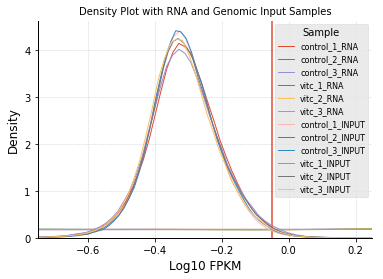

In [149]:
sample_names = ["control_1_RNA", "control_2_RNA", "control_3_RNA", "vitc_1_RNA", "vitc_2_RNA", "vitc_3_RNA", "control_1_INPUT", "control_2_INPUT", "control_3_INPUT", "vitc_1_INPUT", "vitc_2_INPUT", "vitc_3_INPUT"]
fig, ax = plt.subplots()##
plt.title("Density Plot with RNA and Genomic Input Samples", color='black', size = 10)
plt.ylabel("Density", color='black')
plt.xlabel("Log10 FPKM", color='black')
ax.set_facecolor('white')
ax.set_facecolor('white')
ax.tick_params(color='black', labelcolor='black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.grid(color='lightslategray', linestyle='--', linewidth=0.5, alpha=0.4)
ax.set_xlim(-0.75,0.25)
plt.tick_params(axis = 'both', which = 'major', labelsize='10')
plt.axvline(x=-0.05)

for sample in sample_names:
    # Subset to the airline
    subset = table_of_logs[[sample]].values
    
    # Draw the density plot
    sns.distplot(subset, hist = False, kde = True, 
                 kde_kws = {'linewidth': 1}, label = sample)


plt.legend(prop={'size': 8}, title = 'Sample')
#plt.title('Density Plot with RNA and Genomic Input Samples')
#plt.xlabel('Log10 FPKM')
#plt.ylabel('Density')
plt.savefig(Output_Path+"SC_VitC_RNA_LOD_Chart_Zoomed.png", dpi=300) # size above specified at 10x6

From the graphs above, we can see that they cross at -0.05. This is log base 10, so this converts to 0.89125094 FPKM. I am going to use 0.89 as my limit of detection for simplicity. Moving forward, I am going to keep genes that have one or both sample types averages above 0.89 FPKM. These are the ones that will be used for further analysis.

In [150]:
SC_VitC_RNA_FPKM_table.head()

,SC_Control_1_FPKM,SC_Control_2_FPKM,SC_Control_3_FPKM,SC_VitC_1_FPKM,SC_VitC_2_FPKM,SC_VitC_3_FPKM,Control_Average_FPKM,VitC_Average_FPKM,Fold_Change,Log2FC,edgeR,DESeq2,Change
Ensembl_ID,,,,,,,,,,,,,
ENSRNOG00000000001,0.715156,0.486008,0.754285,0.725724,0.903497,0.644060,0.562391,0.757760,1.347391,0.430168,7.507860e-01,6.209275e-01,Nondifferential
ENSRNOG00000000007,0.000000,0.000000,0.000000,0.012158,0.000000,0.011239,0.000000,0.007799,1.000000,0.000000,3.898456e-01,1.000000e+00,Nondifferential
ENSRNOG00000000008,2.411374,2.382310,2.445488,4.776368,4.660176,5.024550,2.391998,4.820365,2.015204,1.010926,3.470000e-12,1.440000e-09,Upregulated
ENSRNOG00000000009,0.000000,0.000000,0.000000,0.000000,0.000000,0.027920,0.000000,0.009307,1.000000,0.000000,6.624017e-01,1.000000e+00,Nondifferential
ENSRNOG00000000010,0.033148,0.026817,0.019001,0.050456,0.031725,0.077740,0.028927,0.053307,1.000000,0.000000,5.854191e-01,1.000000e+00,Nondifferential


In [151]:
SC_VitC_RNA_FPKM_table["Expressed"] = SC_VitC_RNA_FPKM_table.apply(lambda x: ("Expressed") if (x["VitC_Average_FPKM"] > 0.89 or x["Control_Average_FPKM"] > 0.89) else "Below_LOD", axis = 1)

In [152]:
SC_VitC_RNA_FPKM_table.head()

,SC_Control_1_FPKM,SC_Control_2_FPKM,SC_Control_3_FPKM,SC_VitC_1_FPKM,SC_VitC_2_FPKM,SC_VitC_3_FPKM,Control_Average_FPKM,VitC_Average_FPKM,Fold_Change,Log2FC,edgeR,DESeq2,Change,Expressed
Ensembl_ID,,,,,,,,,,,,,,
ENSRNOG00000000001,0.715156,0.486008,0.754285,0.725724,0.903497,0.644060,0.562391,0.757760,1.347391,0.430168,7.507860e-01,6.209275e-01,Nondifferential,Below_LOD
ENSRNOG00000000007,0.000000,0.000000,0.000000,0.012158,0.000000,0.011239,0.000000,0.007799,1.000000,0.000000,3.898456e-01,1.000000e+00,Nondifferential,Below_LOD
ENSRNOG00000000008,2.411374,2.382310,2.445488,4.776368,4.660176,5.024550,2.391998,4.820365,2.015204,1.010926,3.470000e-12,1.440000e-09,Upregulated,Expressed
ENSRNOG00000000009,0.000000,0.000000,0.000000,0.000000,0.000000,0.027920,0.000000,0.009307,1.000000,0.000000,6.624017e-01,1.000000e+00,Nondifferential,Below_LOD
ENSRNOG00000000010,0.033148,0.026817,0.019001,0.050456,0.031725,0.077740,0.028927,0.053307,1.000000,0.000000,5.854191e-01,1.000000e+00,Nondifferential,Below_LOD


In [153]:
SC_VitC_Expressed_Genes = SC_VitC_RNA_FPKM_table[SC_VitC_RNA_FPKM_table["Expressed"] == "Expressed"]

In [154]:
len(SC_VitC_Expressed_Genes)
# We have 11,848 genes left that are expressed

11848

I am a little bummed to see that we only have 11,848 genes left. I think we have more that are really detectable, so I am going to go with the old fashioned way of taking the minimum point between the two humps of only the RNA.


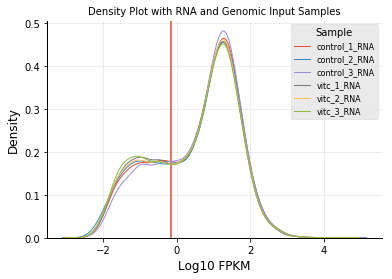

In [155]:
sample_names = ["control_1_RNA", "control_2_RNA", "control_3_RNA", "vitc_1_RNA", "vitc_2_RNA", "vitc_3_RNA"]
fig, ax = plt.subplots()##
plt.title("Density Plot with RNA and Genomic Input Samples", color='black', size = 10)
plt.ylabel("Density", color='black')
plt.xlabel("Log10 FPKM", color='black')
ax.set_facecolor('white')
ax.set_facecolor('white')
ax.tick_params(color='black', labelcolor='black')
ax.spines['bottom'].set_color('black')
ax.spines['left'].set_color('black')
ax.grid(color='lightslategray', linestyle='--', linewidth=0.5, alpha=0.4)
#ax.set_xlim(-0.75,0.25)
plt.tick_params(axis = 'both', which = 'major', labelsize='10')
plt.axvline(x=-0.15)

for sample in sample_names:
    # Subset to the airline
    subset = table_of_logs[[sample]].values
    
    # Draw the density plot
    sns.distplot(subset, hist = False, kde = True, 
                 kde_kws = {'linewidth': 1}, label = sample)


plt.legend(prop={'size': 8}, title = 'Sample')
#plt.title('Density Plot with RNA and Genomic Input Samples')
#plt.xlabel('Log10 FPKM')
#plt.ylabel('Density')
plt.savefig(Output_Path+"SC_VitC_RNA_LOD_Chart_Zoomed.png", dpi=300) # size above specified at 10x6

If I change the line to -0.15, it changes the LOD to only 0.71, which I think is more reasonable. I am going to try that. 

In [156]:
SC_VitC_RNA_FPKM_table["Expressed"] = SC_VitC_RNA_FPKM_table.apply(lambda x: ("Expressed") if (x["VitC_Average_FPKM"] > 0.71 or x["Control_Average_FPKM"] > 0.71) else "Below_LOD", axis = 1)
SC_VitC_Expressed_Genes = SC_VitC_RNA_FPKM_table[SC_VitC_RNA_FPKM_table["Expressed"] == "Expressed"]
len(SC_VitC_Expressed_Genes)
# We have 12,152 genes left that are expressed
# I guess that is a few more to look at. 

12152

In [157]:
print("Downregulated Genes:", len(SC_VitC_Expressed_Genes[SC_VitC_Expressed_Genes["Change"] == "Downregulated"]))
print("Upregulated Genes:",len(SC_VitC_Expressed_Genes[SC_VitC_Expressed_Genes["Change"] == "Upregulated"]))
print("Nondifferential Genes:",len(SC_VitC_Expressed_Genes[SC_VitC_Expressed_Genes["Change"] == "Nondifferential"]))

Downregulated Genes: 1798
Upregulated Genes: 1984
Nondifferential Genes: 8370


In [158]:
SC_VitC_Expressed_Genes.to_csv(Output_Path+"SC_VitC_Expressed_RNA.csv")
SC_VitC_Expressed_Genes.to_pickle(Output_Path+"SC_VitC_Expressed_RNA.pkl")

We can see that we have 1,984 genes that go up and 1,798 genes that go down after treatement with vitamin C. This is much lower than the 8,370 genes that do not change after treatment. This matches the assumption that most genes will not change, and indicates that our treatment was not too extreme.

Now I have a table of the expressed genes, as well as the information about how they react to vitamin C treatment.
The next step is going to be to integrate this with the information that we have generated about the hMeDIP peaks.

In [159]:
SC_VitC_Expressed_Genes = pd.read_pickle(Output_Path+"SC_VitC_Expressed_RNA.pkl")
Rat_Genomic_Info_File = pd.read_csv(Input_genomic_info_file, sep = ",", index_col = 0 )
summed_counts = pd.read_pickle(Output_Path+"SC_VitC_Counts_of_peaks_per_region.pkl")

In [160]:
Rat_Genomic_Info_File.head()

,Gene_Name,Location,Sense,Gene_Biotype,transcript_id,Chr,Start,Stop,Length,Exon Length,Intron Length,Gene_ID,gene_version,transcript_version,gene_name,gene_source,gene_biotype,transcript_name,transcript_source,transcript_biotype
Ensembl_ID,,,,,,,,,,,,,,,,,,,,
ENSRNOG00000000001,AABR07013255.1,chr2:230660664-230662084,+,pseudogene,ENSRNOT00000055633,2,230660664,230662084,1421,1416,5,ENSRNOG00000000001,5,2,AABR07013255.1,ensembl,pseudogene,AABR07013255.1-201,ensembl,pseudogene
ENSRNOG00000000007,Gad1,chr3:56861396-56902157,+,protein_coding,ENSRNOT00000087712,3,56862691,56902137,39447,3381,36066,ENSRNOG00000000007,7,1,Gad1,ensembl,protein_coding,Gad1-204,ensembl,protein_coding
ENSRNOG00000000008,Alx4,chr3:82548959-82585531,+,protein_coding,ENSRNOT00000000009,3,82548959,82585531,36573,1747,34826,ENSRNOG00000000008,7,5,Alx4,ensembl,protein_coding,Alx4-201,ensembl,protein_coding
ENSRNOG00000000009,Tmco5b,chr3:104749051-104765436,+,protein_coding,ENSRNOT00000000010,3,104749051,104765436,16386,1361,15025,ENSRNOG00000000009,5,5,Tmco5b,ensembl,protein_coding,Tmco5b-201,ensembl,protein_coding
ENSRNOG00000000010,Cbln1,chr19:20607507-20611316,+,protein_coding,ENSRNOT00000000011,19,20607507,20611316,3810,2444,1366,ENSRNOG00000000010,5,5,Cbln1,ensembl,protein_coding,Cbln1-201,ensembl,protein_coding


In [161]:
labels = SC_VitC_Expressed_Genes[["Change"]]
relevant_genomic_info = Rat_Genomic_Info_File[["Gene_Name", "Gene_Biotype", "Chr", "Length", "Exon Length"]]

In [162]:
labels.head()

,Change
Ensembl_ID,
ENSRNOG00000000001,Nondifferential
ENSRNOG00000000008,Upregulated
ENSRNOG00000000017,Nondifferential
ENSRNOG00000000021,Nondifferential
ENSRNOG00000000024,Nondifferential


In [163]:
relevant_genomic_info.head()

,Gene_Name,Gene_Biotype,Chr,Length,Exon Length
Ensembl_ID,,,,,
ENSRNOG00000000001,AABR07013255.1,pseudogene,2,1421,1416
ENSRNOG00000000007,Gad1,protein_coding,3,39447,3381
ENSRNOG00000000008,Alx4,protein_coding,3,36573,1747
ENSRNOG00000000009,Tmco5b,protein_coding,3,16386,1361
ENSRNOG00000000010,Cbln1,protein_coding,19,3810,2444


In [164]:
expressed_genes_info = labels.join(relevant_genomic_info)

In [165]:
expressed_genes_info.groupby(["Gene_Biotype"], as_index = False).size()

Gene_Biotype
0                                      44
Mt_rRNA                                 2
Mt_tRNA                                10
TEC                                     3
antisense_RNA                          11
lincRNA                               208
miRNA                                 106
misc_RNA                               33
processed_pseudogene                  138
processed_transcript                   33
protein_coding                      11218
pseudogene                            169
rRNA                                    2
ribozyme                                4
scaRNA                                  7
snRNA                                  77
snoRNA                                 77
transcribed_processed_pseudogene        2
unprocessed_pseudogene                  8
dtype: int64

It is not surprising that the majority of the expressed genes (11,218 of the 12,152) are protein coding genes. It looks like the next most common is lincRNA (208) and pseudogenes (169). I may join all of the noncoding types together for further anaylsis.

In [166]:
expressed_genes_info = expressed_genes_info.join(summed_counts)
expressed_genes_info = expressed_genes_info.fillna(0)

In [167]:
expressed_genes_info.head()

,Change,Gene_Name,Gene_Biotype,Chr,Length,Exon Length,Downstream_Promoter_Downregulated,Upstream_Promoter_Downregulated,Gene_Body_Downregulated,TSS_Downregulated,Downstream_Promoter_Nondifferential,Upstream_Promoter_Nondifferential,Gene_Body_Nondifferential,TSS_Nondifferential,Downstream_Promoter_Upregulated,Upstream_Promoter_Upregulated,Gene_Body_Upregulated,TSS_Upregulated
Ensembl_ID,,,,,,,,,,,,,,,,,,
ENSRNOG00000000001,Nondifferential,AABR07013255.1,pseudogene,2,1421,1416,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSRNOG00000000008,Upregulated,Alx4,protein_coding,3,36573,1747,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,1.0,1.0,4.0,0.0
ENSRNOG00000000017,Nondifferential,Steap1,protein_coding,4,10589,1280,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSRNOG00000000021,Nondifferential,AABR07061902.1,pseudogene,4,1202,1200,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ENSRNOG00000000024,Nondifferential,Hebp1,protein_coding,4,29515,1062,0.0,0.0,1.0,0.0,0.0,0.0,5.0,0.0,0.0,0.0,2.0,0.0


In [168]:
expressed_genes_info.describe()

,Length,Exon Length,Downstream_Promoter_Downregulated,Upstream_Promoter_Downregulated,Gene_Body_Downregulated,TSS_Downregulated,Downstream_Promoter_Nondifferential,Upstream_Promoter_Nondifferential,Gene_Body_Nondifferential,TSS_Nondifferential,Downstream_Promoter_Upregulated,Upstream_Promoter_Upregulated,Gene_Body_Upregulated,TSS_Upregulated
count,1.215200e+04,12152.000000,12152.000000,12152.000000,12152.000000,12152.000000,12152.000000,12152.000000,12152.000000,12152.000000,12152.000000,12152.000000,12152.000000,12152.000000
mean,4.200248e+04,2590.660303,0.023700,0.028061,0.388660,0.002222,0.135369,0.137837,2.314269,0.015800,0.262755,0.184414,3.384052,0.027403
std,7.477106e+04,1940.736936,0.154267,0.168118,1.120189,0.047086,0.374075,0.377340,5.006940,0.126019,0.522557,0.453929,7.755123,0.166752
min,4.900000e+01,49.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,6.241000e+03,1336.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,1.847350e+04,2148.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000
75%,4.660600e+04,3387.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,0.000000,0.000000,3.000000,0.000000
max,2.232523e+06,25658.000000,2.000000,2.000000,30.000000,1.000000,5.000000,4.000000,107.000000,2.000000,4.000000,5.000000,148.000000,2.000000


In [169]:
expressed_genes_info.to_csv("Output_Tables_and_Results/SC_VitC_Combined_Cleaned_Data.csv")
expressed_genes_info.to_pickle("Output_Tables_and_Results/SC_VitC_Combined_Cleaned_Data.pkl")


This is the finally cleaned data. I realize that I did not need to have all of the steps for finding outliers to get the table this way, but it was needed to accurately determine the fold change, which might end up being used in this project and will very likely be used in other projects. Additionally, the corrected FPKM values are needed for heatmaps and were needed to determine the expression threshold. 

Exploration of the data has shown that there are slightly more upregulated genes than downregulated genes in the SC Vitamin C dataset, but this is still only about 1/3 of the expressed genes (12,152). About 90% of the expressed genes are protein coding genes (11,218), even though they make up a relatively small portion of the annotated genome. This is consistent with other RNA-seq studies in Rat, and there are probably more noncoding genes, but they aren't as well annotated in rats. It looks like the highest average peak counts are genebody upregulated (3.38) followed by genebody nondifferential (2.3). We now have many dimensions and this should be helpful for determining if we can classify genes based on the genomic info and hMeDIP peak information (data about DNA methylation). 